# Libraries

In [26]:
import os, time, joblib, json
from statistics import mean

# visualisation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scikitplot.estimators import plot_learning_curve
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.model_selection import learning_curve
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams["savefig.facecolor"] = "0.8"
plt.rcParams.update({"figure.figsize": (15, 5), "figure.dpi": 120})
plt.style.use("seaborn")

import scikitplot as skplt
from plot_metric.functions import BinaryClassification
# import metriculous

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler
from imblearn.combine import SMOTEENN

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

# Cross validation
from sklearn.model_selection import RepeatedStratifiedKFold

# Model building
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

# AutoML / Hypermeter optimization tools
import optuna
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
# from hpsklearn import HyperoptEstimator, any_classifier
# from hyperopt import tpe
# from tpot import TPOTClassifier()

# Explainability
import shap
# import lime
# import lime.lime_tabular
# from sklearn.inspection import permutation_importance
# from deepchecks import TrainTestFeatureDrift
# from deepchecks.tabular.feature_importance import calculate_feature_importance

# model export
import pickle as pck

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data Fetching

In [2]:
# define train/test files path
train_path = os.path.join("../data/train.txt")
test_path = os.path.join("../data/test.txt")

# Data Parsing

In [29]:
# define train/test dataframes
df_train = pd.read_csv(train_path, low_memory=False)
df_test = pd.read_csv(test_path, low_memory=False)

In [4]:
# dataset overview
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [8]:
# dataset summary
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [22]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         357 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      344 non-null    object 
 6   ApplicantIncome    367 non-null    int64  
 7   CoapplicantIncome  367 non-null    int64  
 8   LoanAmount         362 non-null    float64
 9   Loan_Amount_Term   361 non-null    float64
 10  Credit_History     338 non-null    float64
 11  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


In [9]:
# dataset statistic
df_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [112]:
# dataset null/NaN values count
np.round(df_train.isnull().sum())

gender               13
married               3
dependents           15
education             0
self_employed        32
applicantincome       0
coapplicantincome     0
loanamount           22
loan_amount_term     14
credit_history       50
property_area         0
loan_status           0
dtype: int64

In [7]:
# dataset duplicates count
df_train[df_train.duplicated(keep=False)].sum()

Loan_ID              0.0
Gender               0.0
Married              0.0
Dependents           0.0
Education            0.0
Self_Employed        0.0
ApplicantIncome      0.0
CoapplicantIncome    0.0
LoanAmount           0.0
Loan_Amount_Term     0.0
Credit_History       0.0
Property_Area        0.0
Loan_Status          0.0
dtype: float64

# Exploratory data analysis

In [5]:
# renaming columns for better readability
df_train.columns = df_train.columns.str.lower()

In [6]:
# drop uneedeed/obselete features
df_train = df_train.drop("loan_id", axis=1) 

In [113]:
df_train.head()

,gender,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,loan_status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [19]:
df_test

,loan_id,gender,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...,...
362,LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban
363,LP002975,Male,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban
364,LP002980,Male,No,0,Graduate,No,3250,1993,126.0,360.0,NaN,Semiurban
365,LP002986,Male,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural


In [8]:
# define dataframe for visualization
df_analysis = df_train.copy()

In [60]:
# Define continuous / categorical features
categorical_fts = ["gender", "married", "dependents", "education", "self_employed", "credit_history", "property_area"]
continuous_fts = [col for col in df_analysis.columns if df_analysis[col].dtype not in categorical_fts]

## Univariate analysis

### Distribution plots

In [10]:
# target label encoding target for visualization
df_analysis["loan_status"] = LabelEncoder().fit_transform(df_analysis["loan_status"])

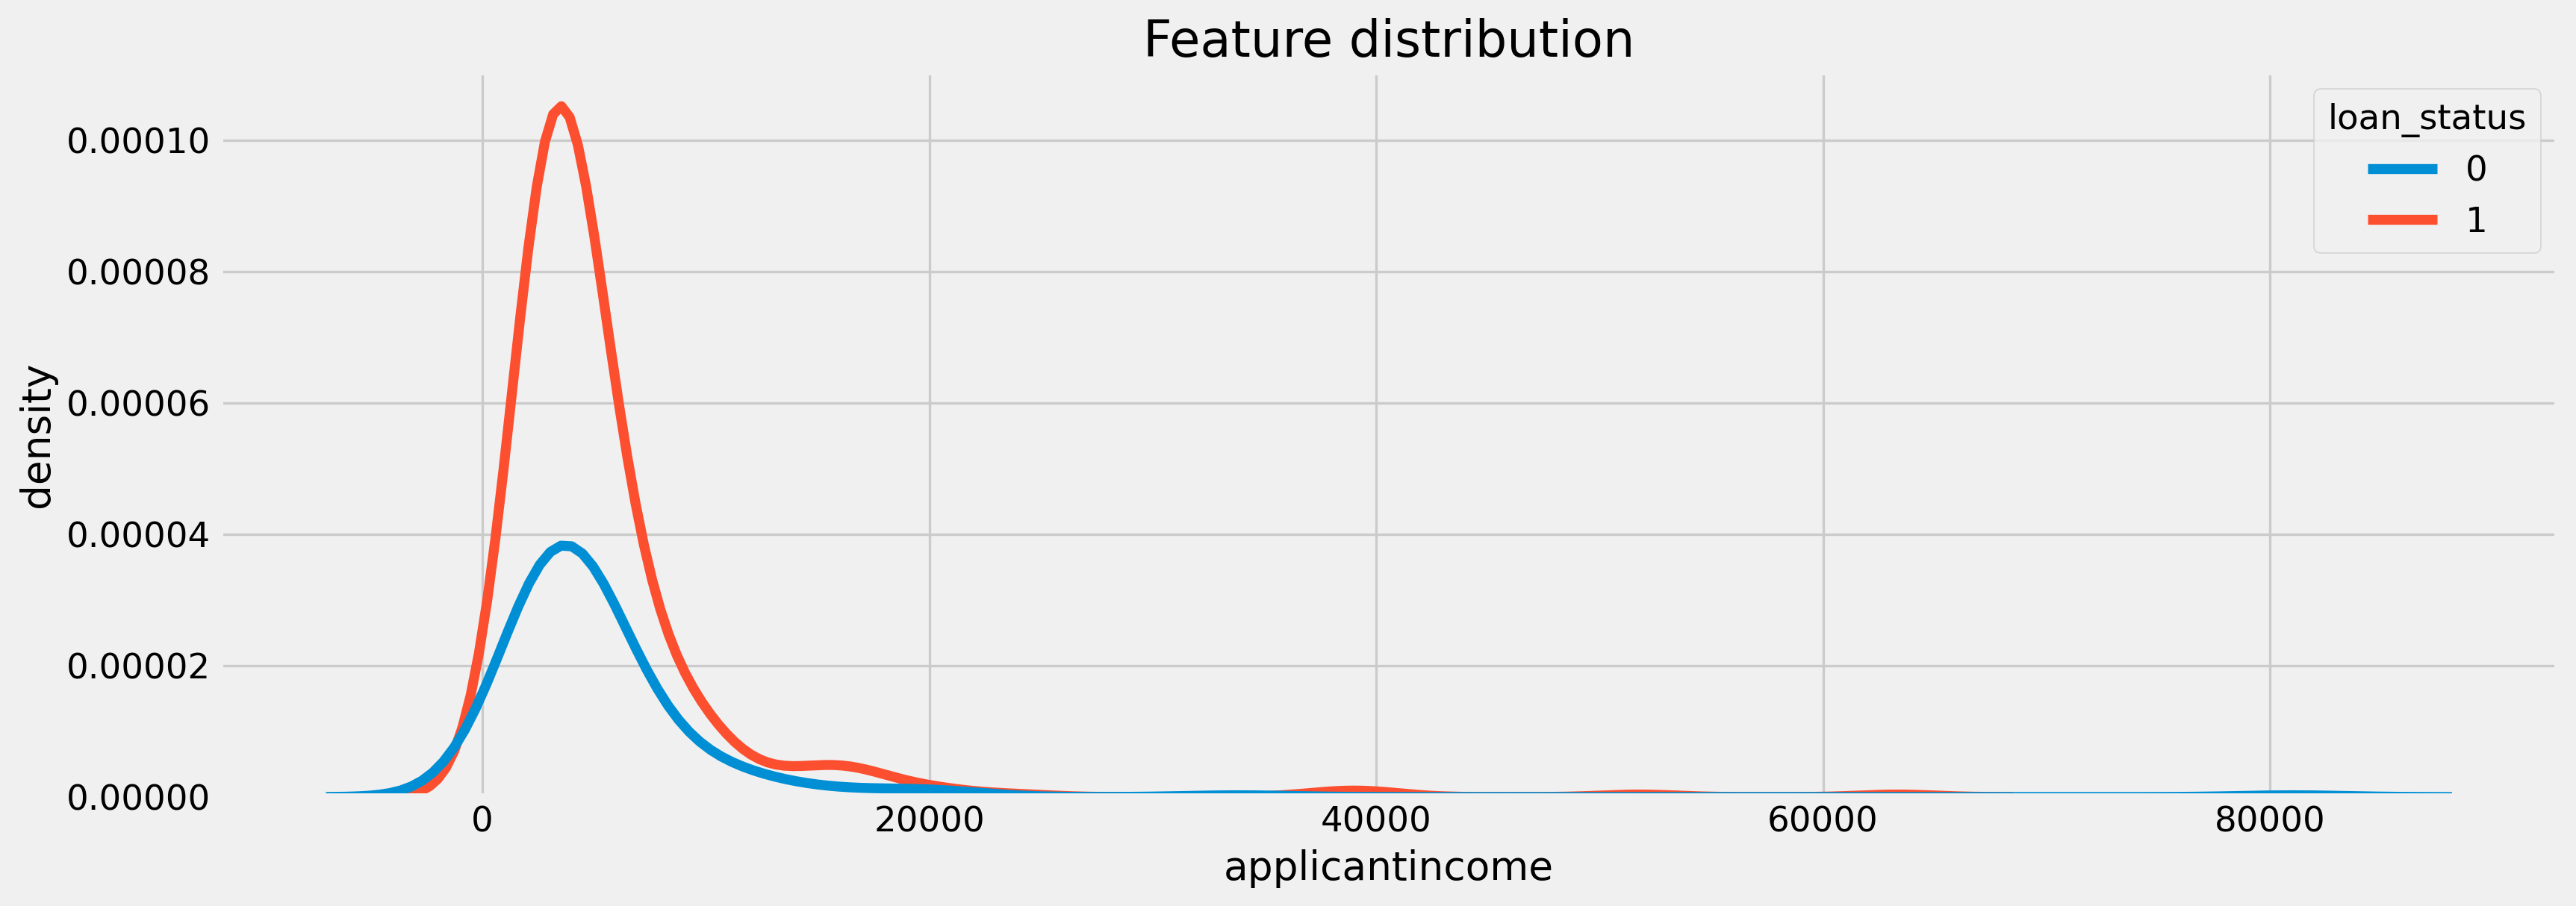

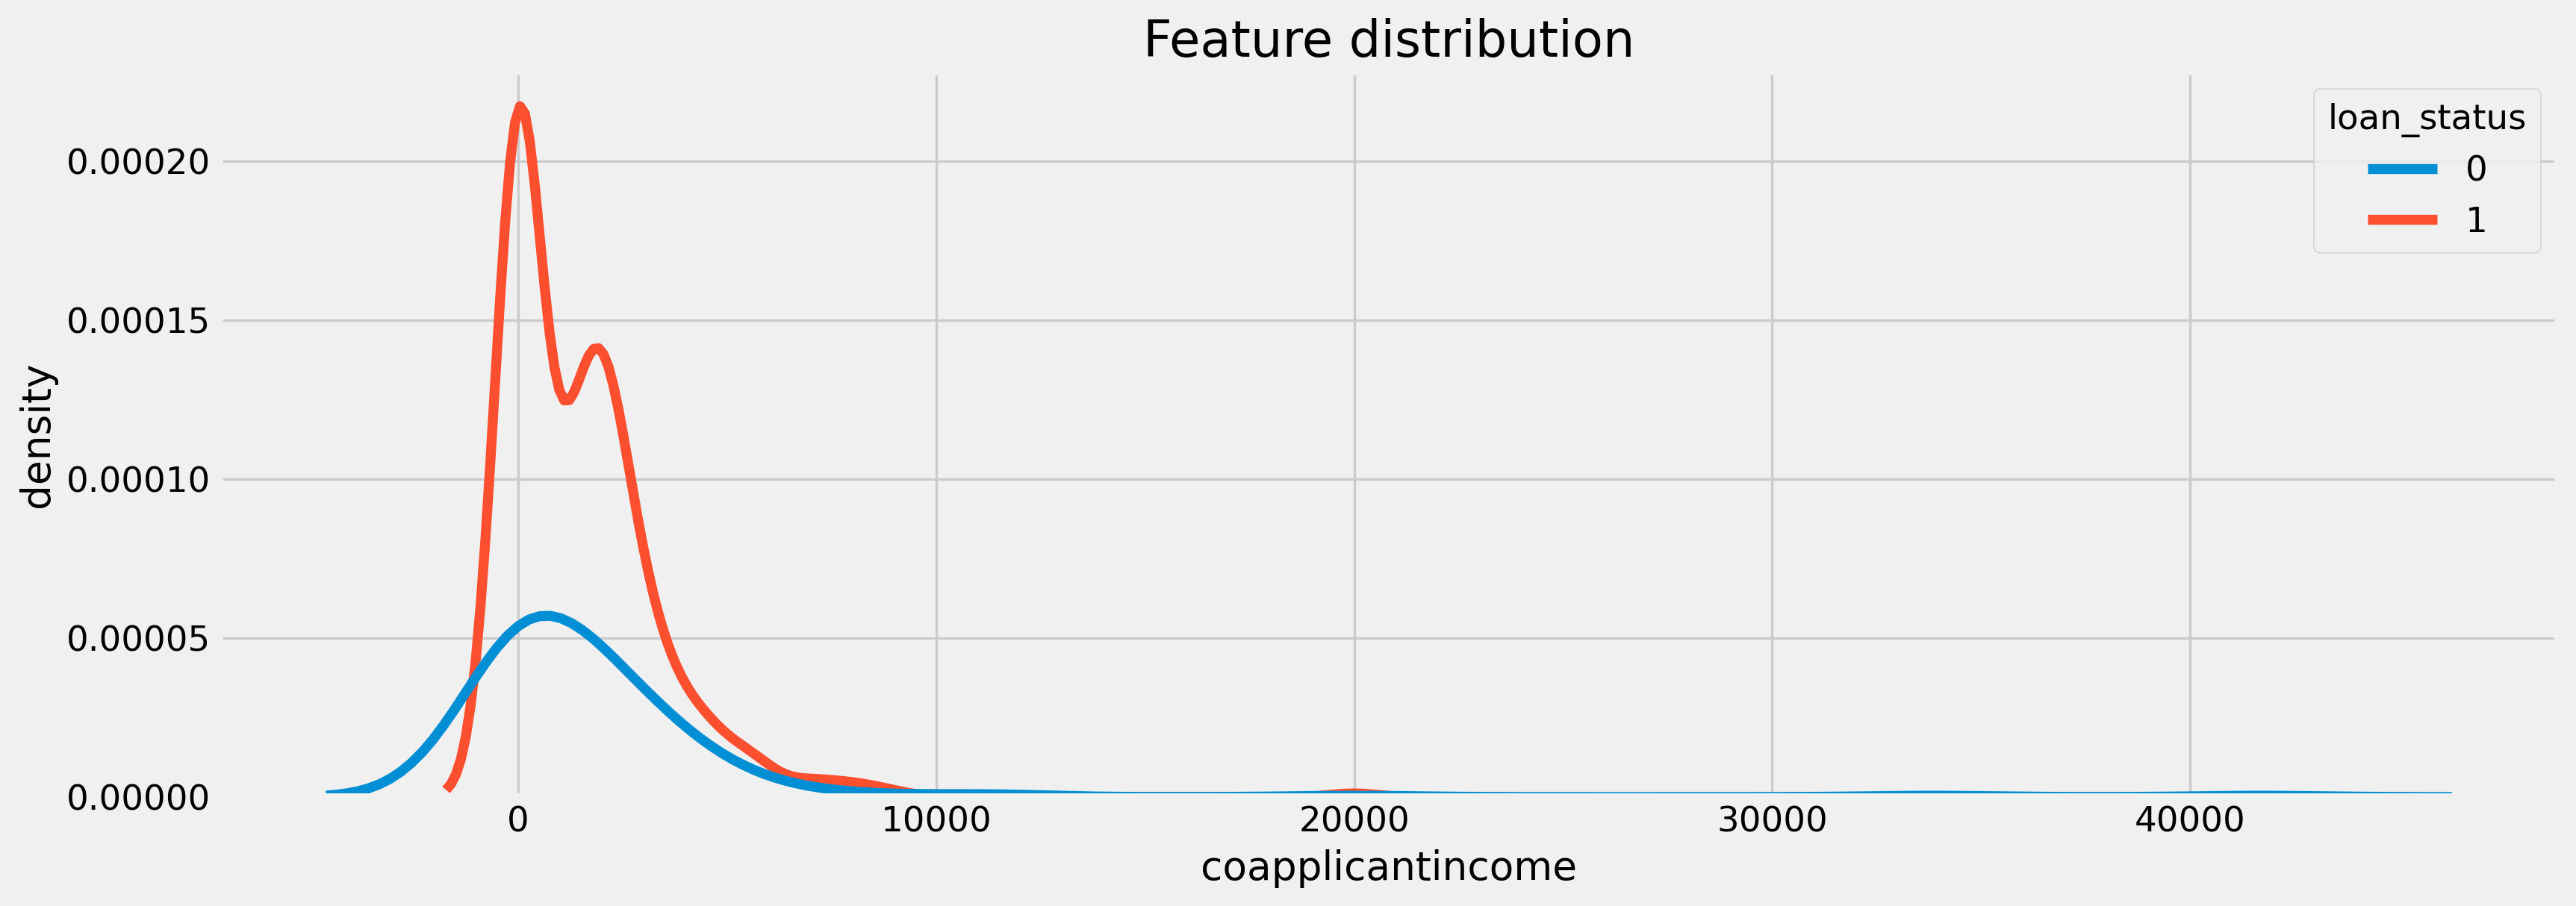

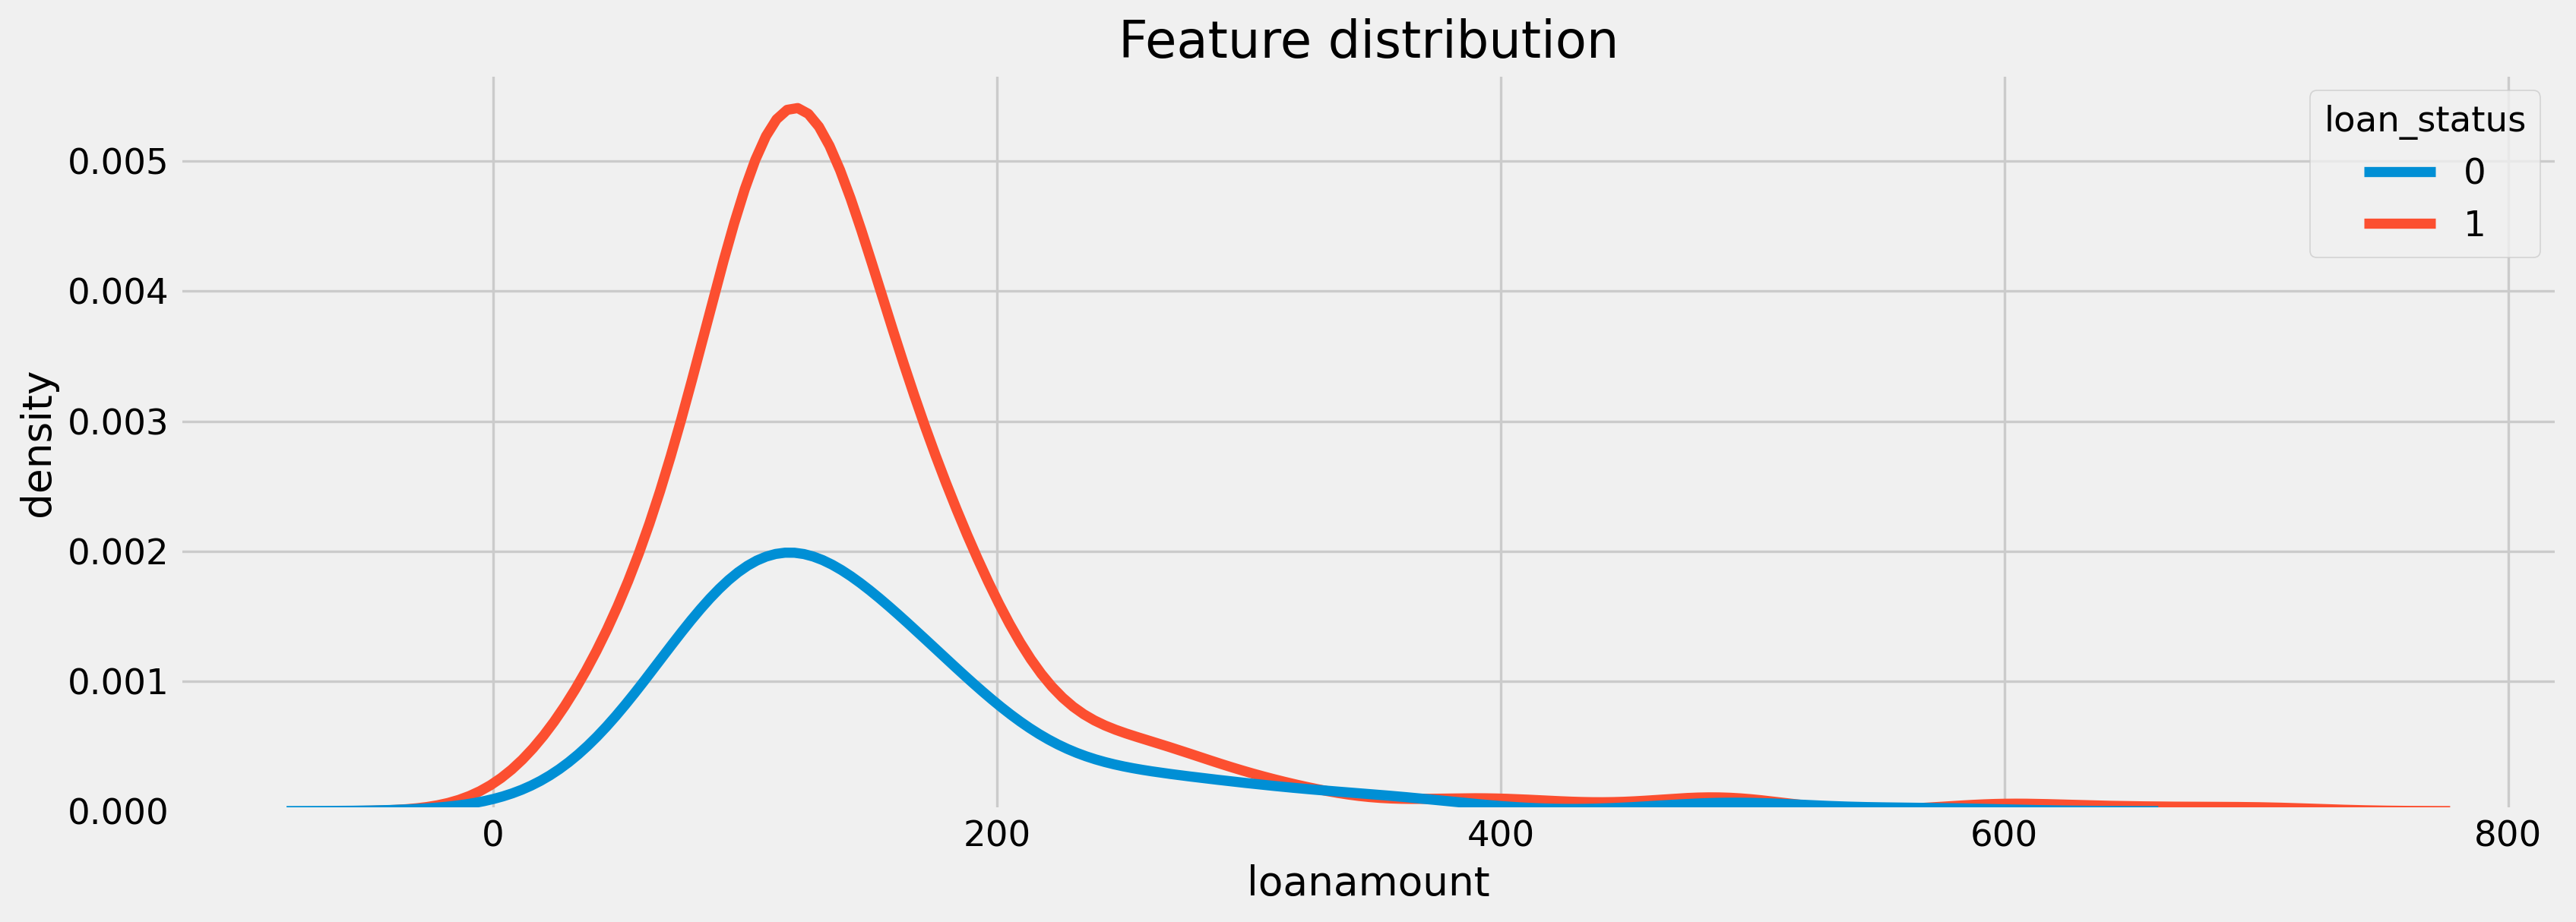

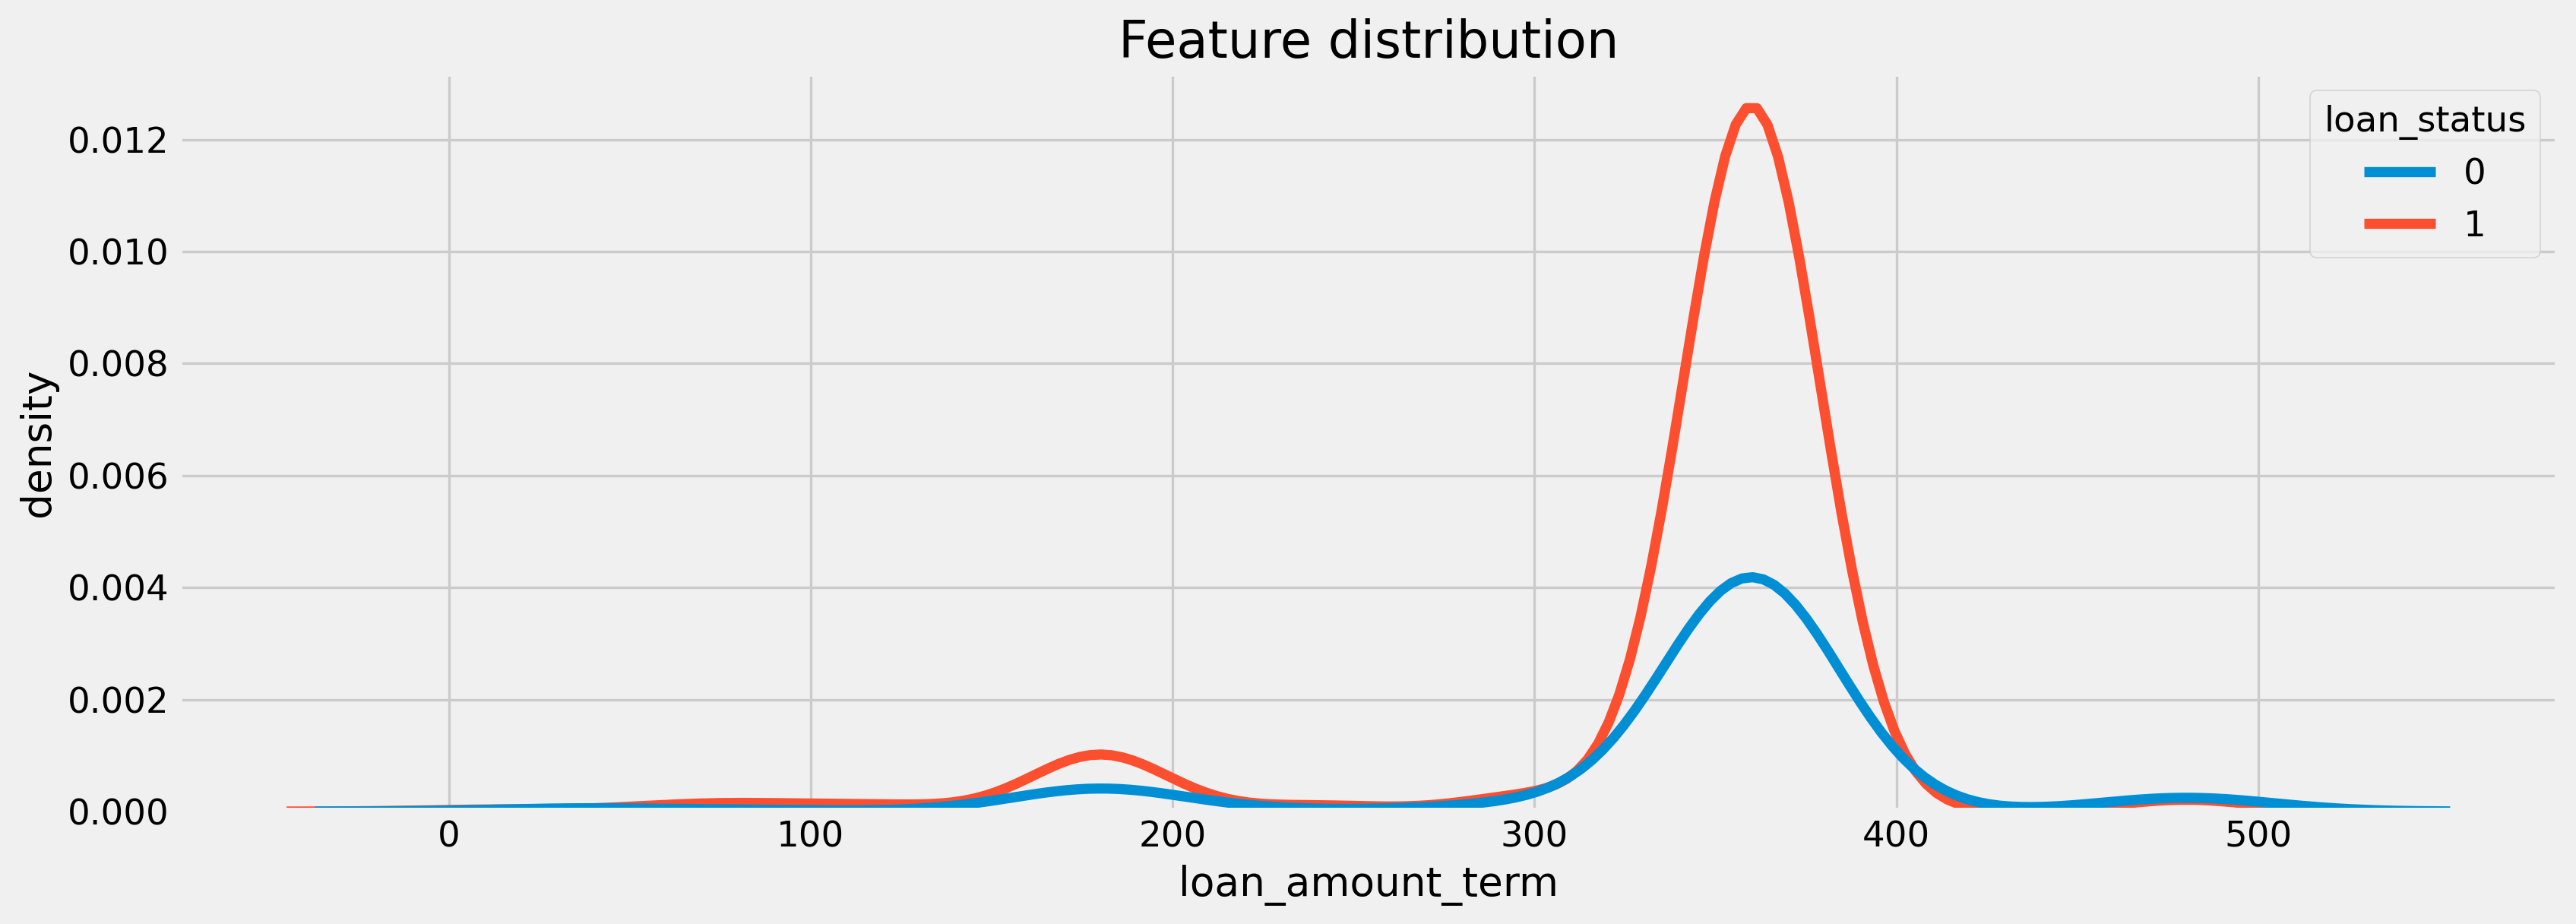

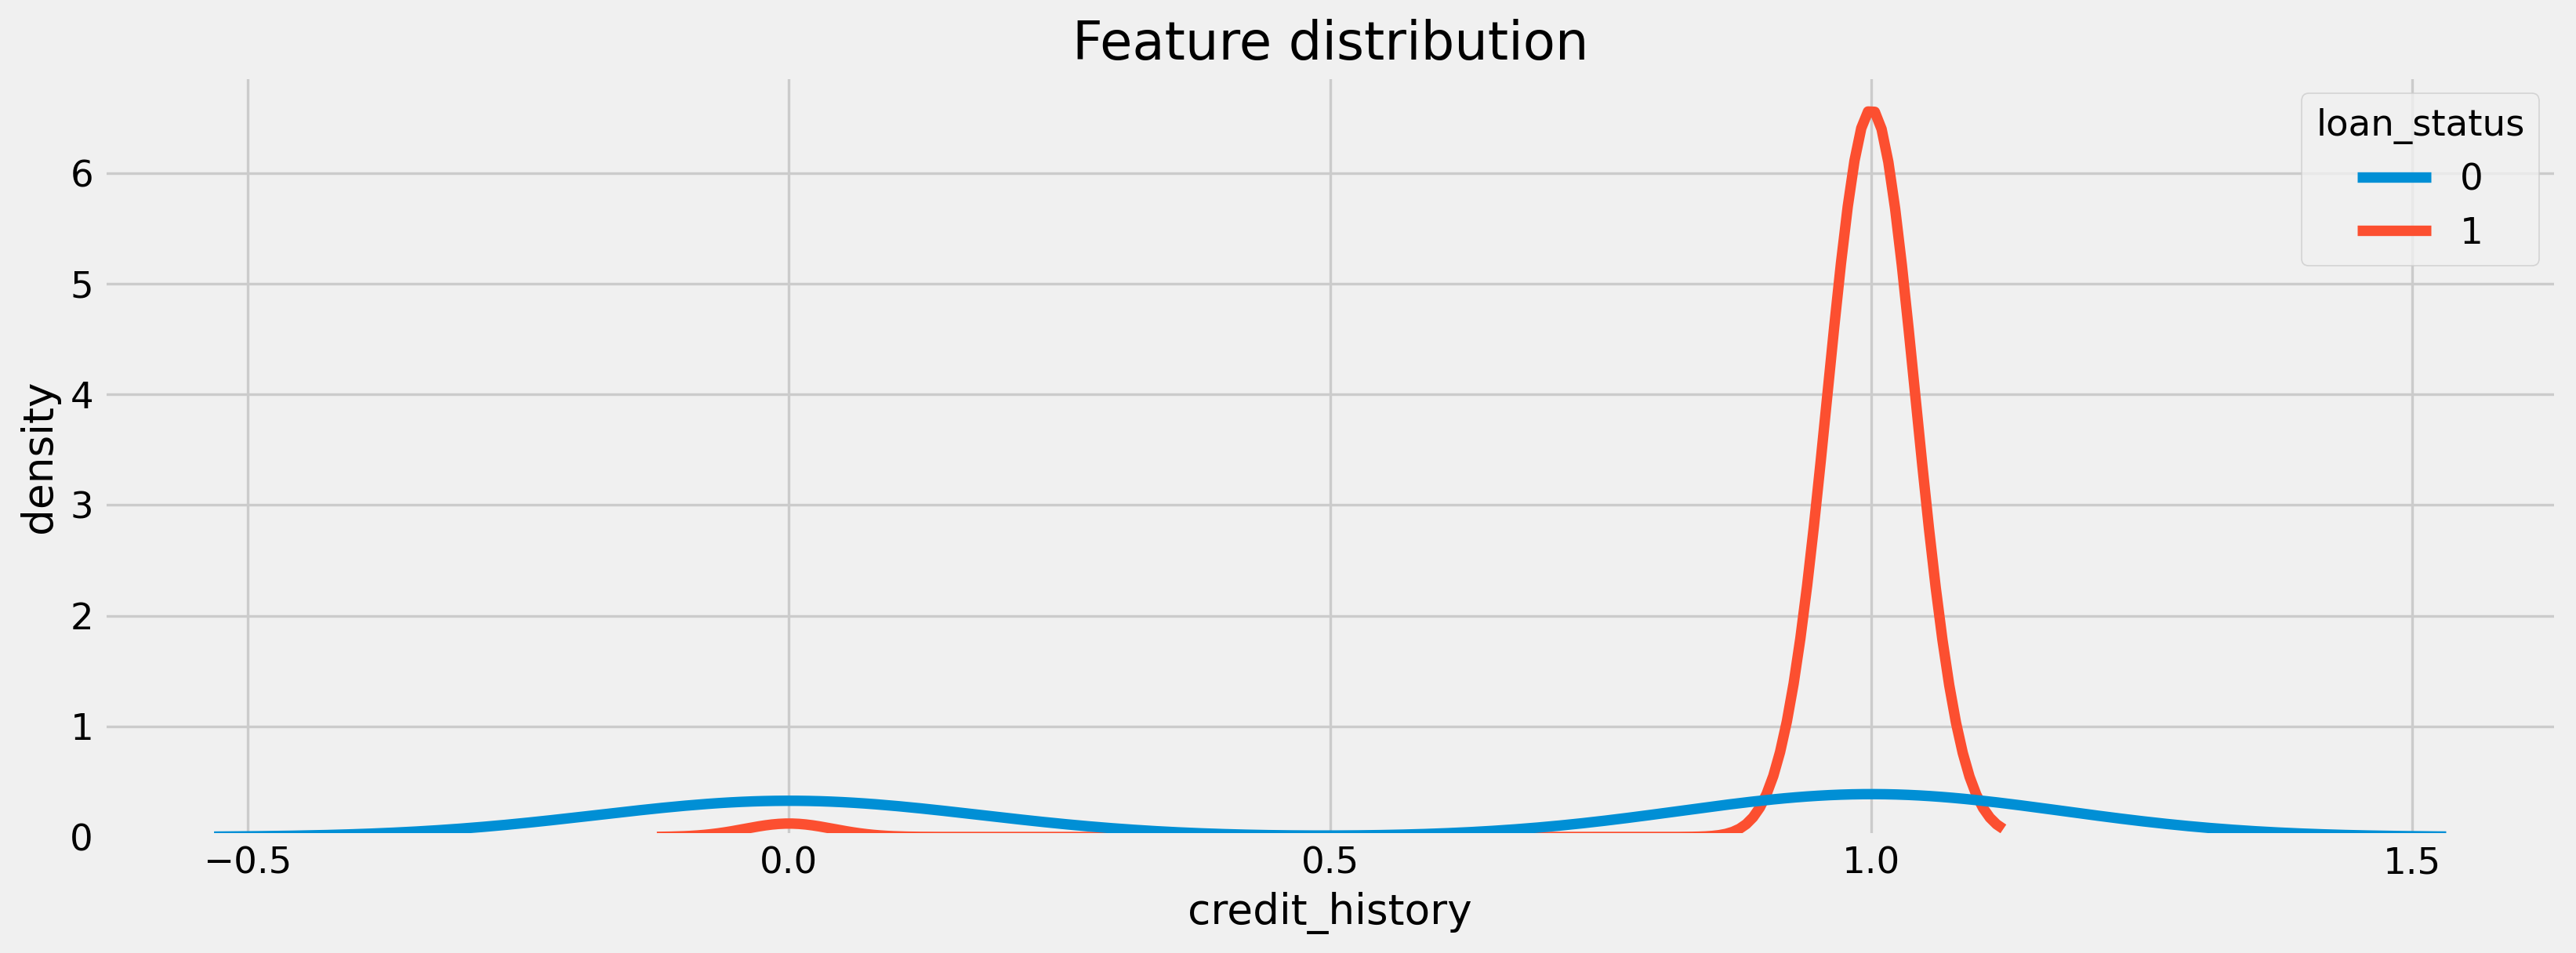

In [98]:
# plot continuous numeric features distribution against target
for i in continuous_fts:
    plt.figure()
    plt.title("Feature distribution")
    plt.xlabel(i, fontsize=16)
    plt.ylabel("density", fontsize=16)
    sns.kdeplot(df_analysis[i], hue=df_analysis["loan_status"])

plt.savefig("../reports/eda/num_ftr_distribution.png")
plt.show()

### Count plots

In [11]:
# drop target feature from categorical features list
categorical_fts.remove("loan_status")

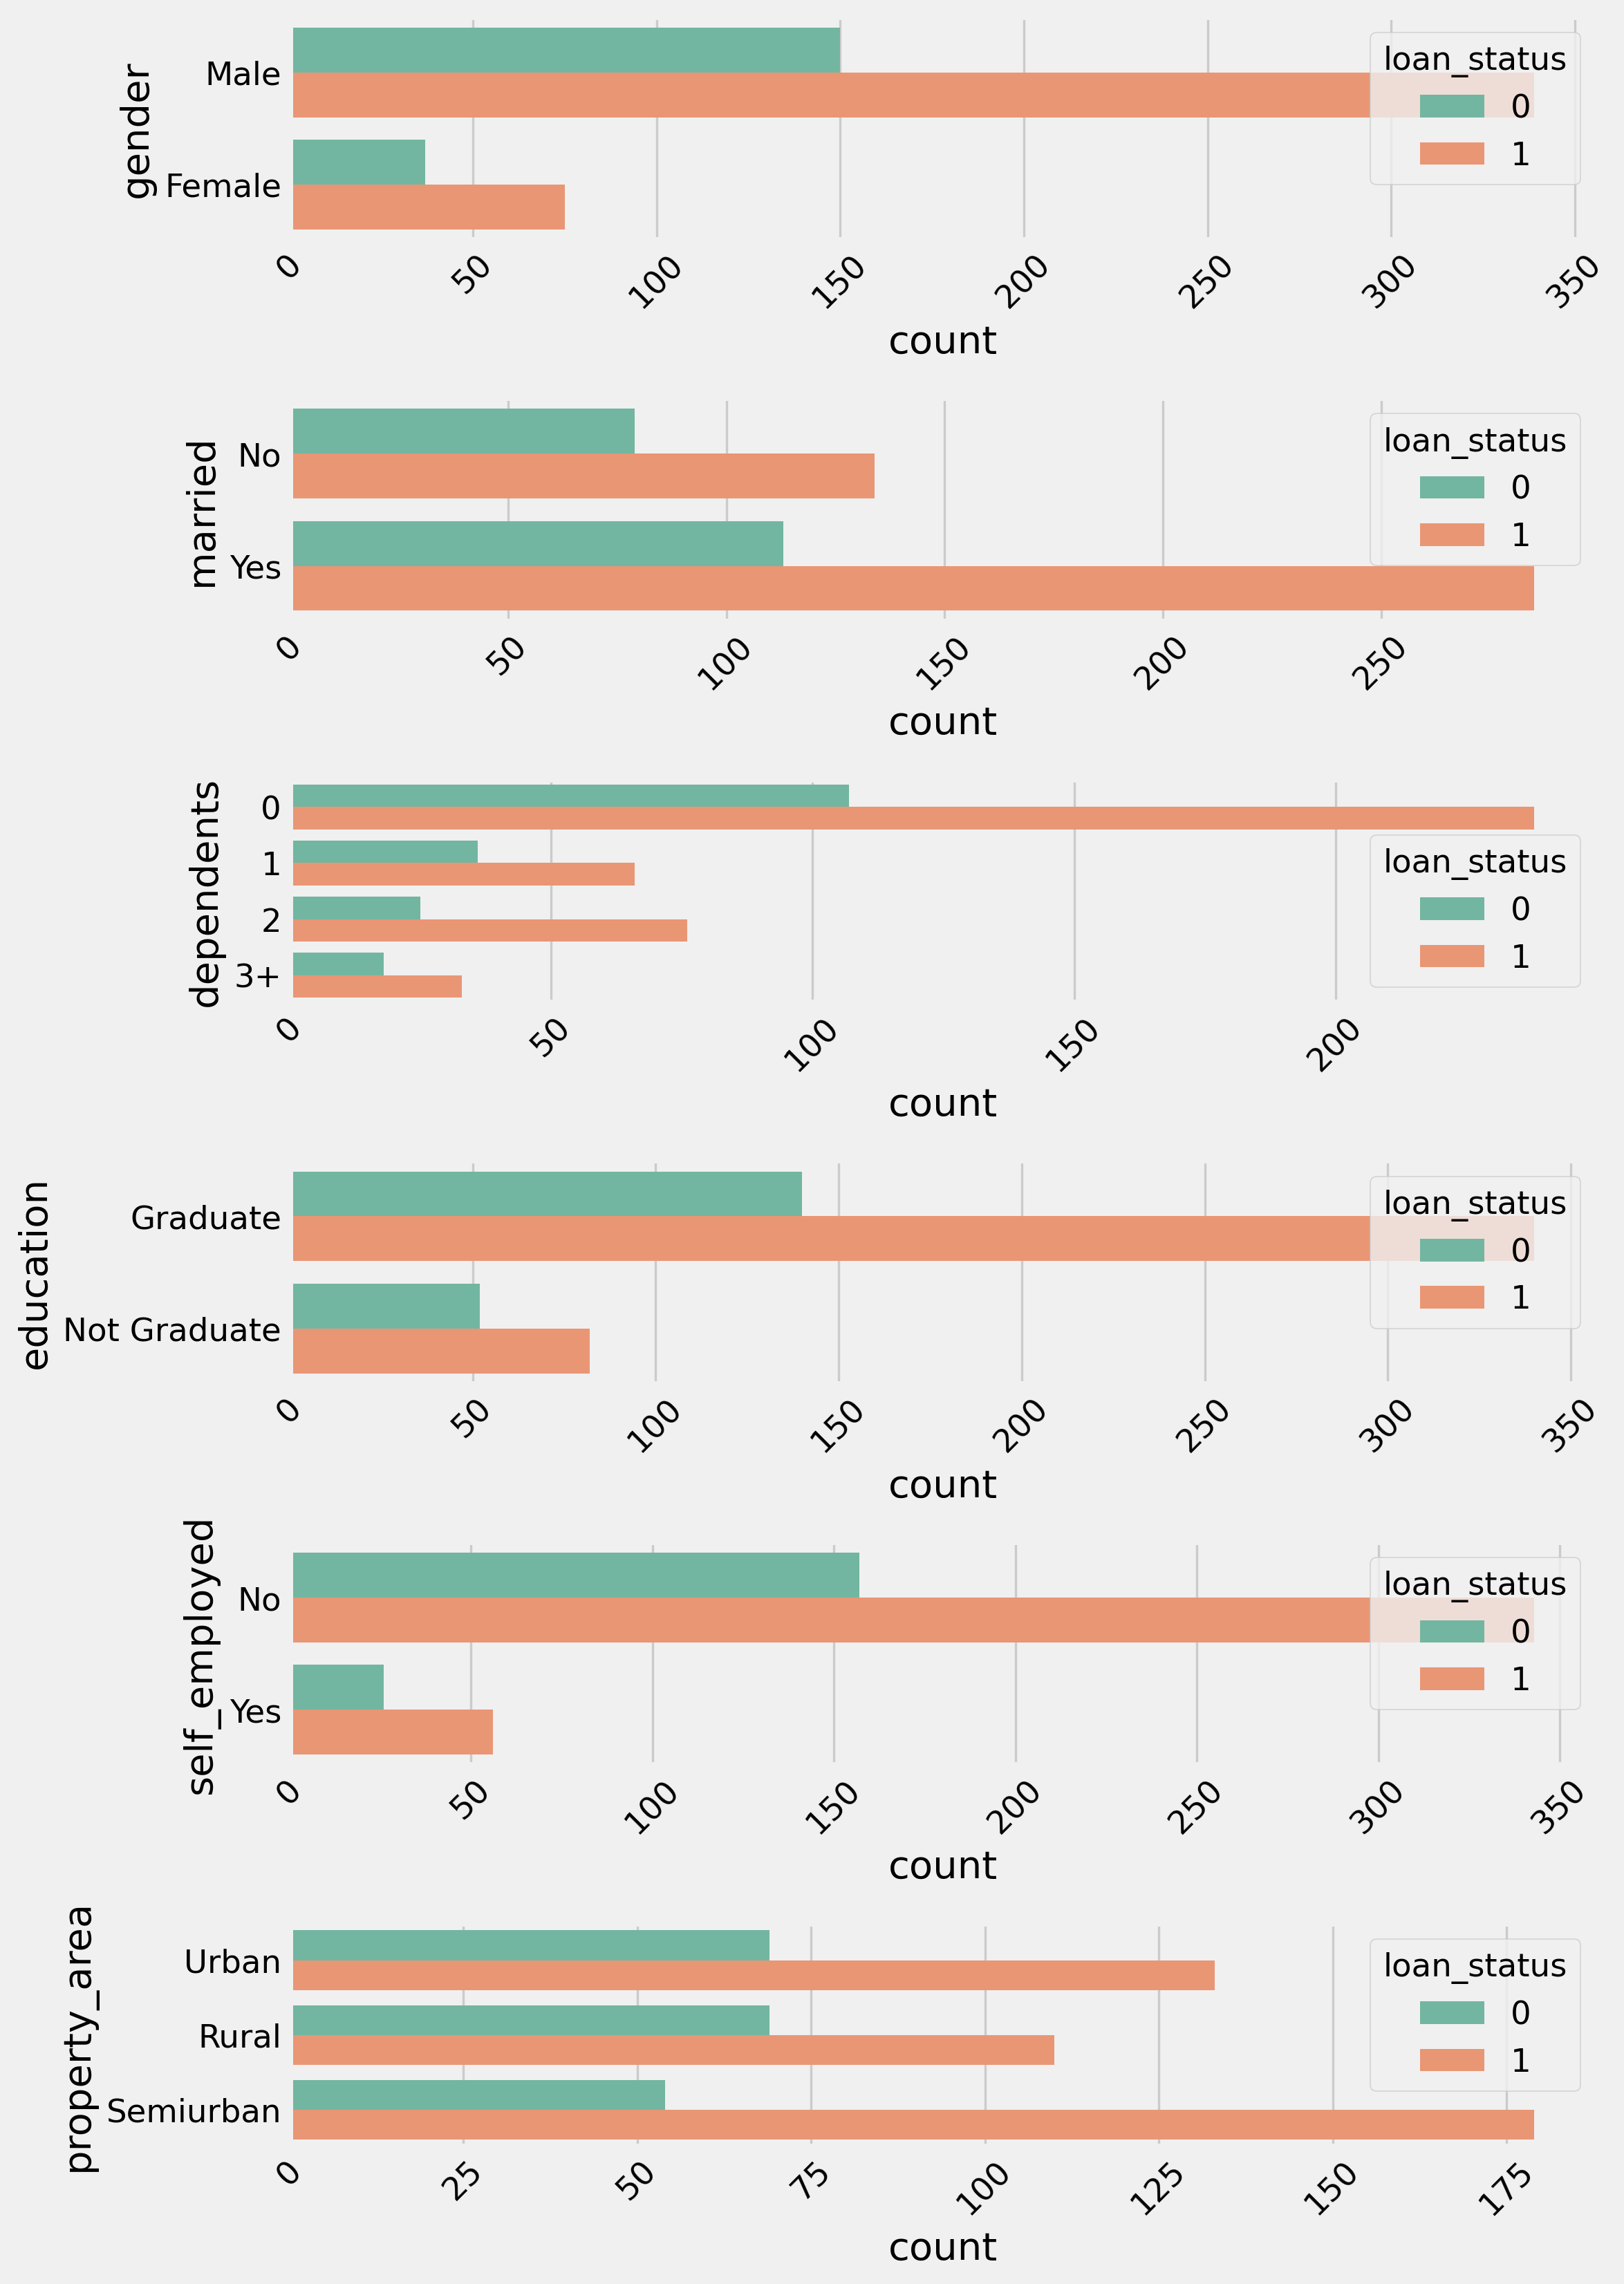

In [90]:
# count plot categorical features
c_map = sns.color_palette("Set2")

fig, axes = plt.subplots(len(categorical_fts), figsize=(10, 14))
for i, ax in enumerate(axes):
    sns.countplot(y=categorical_fts[i], data=df_analysis[categorical_fts], hue=df_analysis["loan_status"], palette=c_map, ax=ax)

# rotate x-axis for every single plot
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

# set spacing for every subplot, else x-axis will be covered
plt.tight_layout()

# export report figure
plt.savefig("../reports/eda/ctg_ftr_count.png")

### Box plots

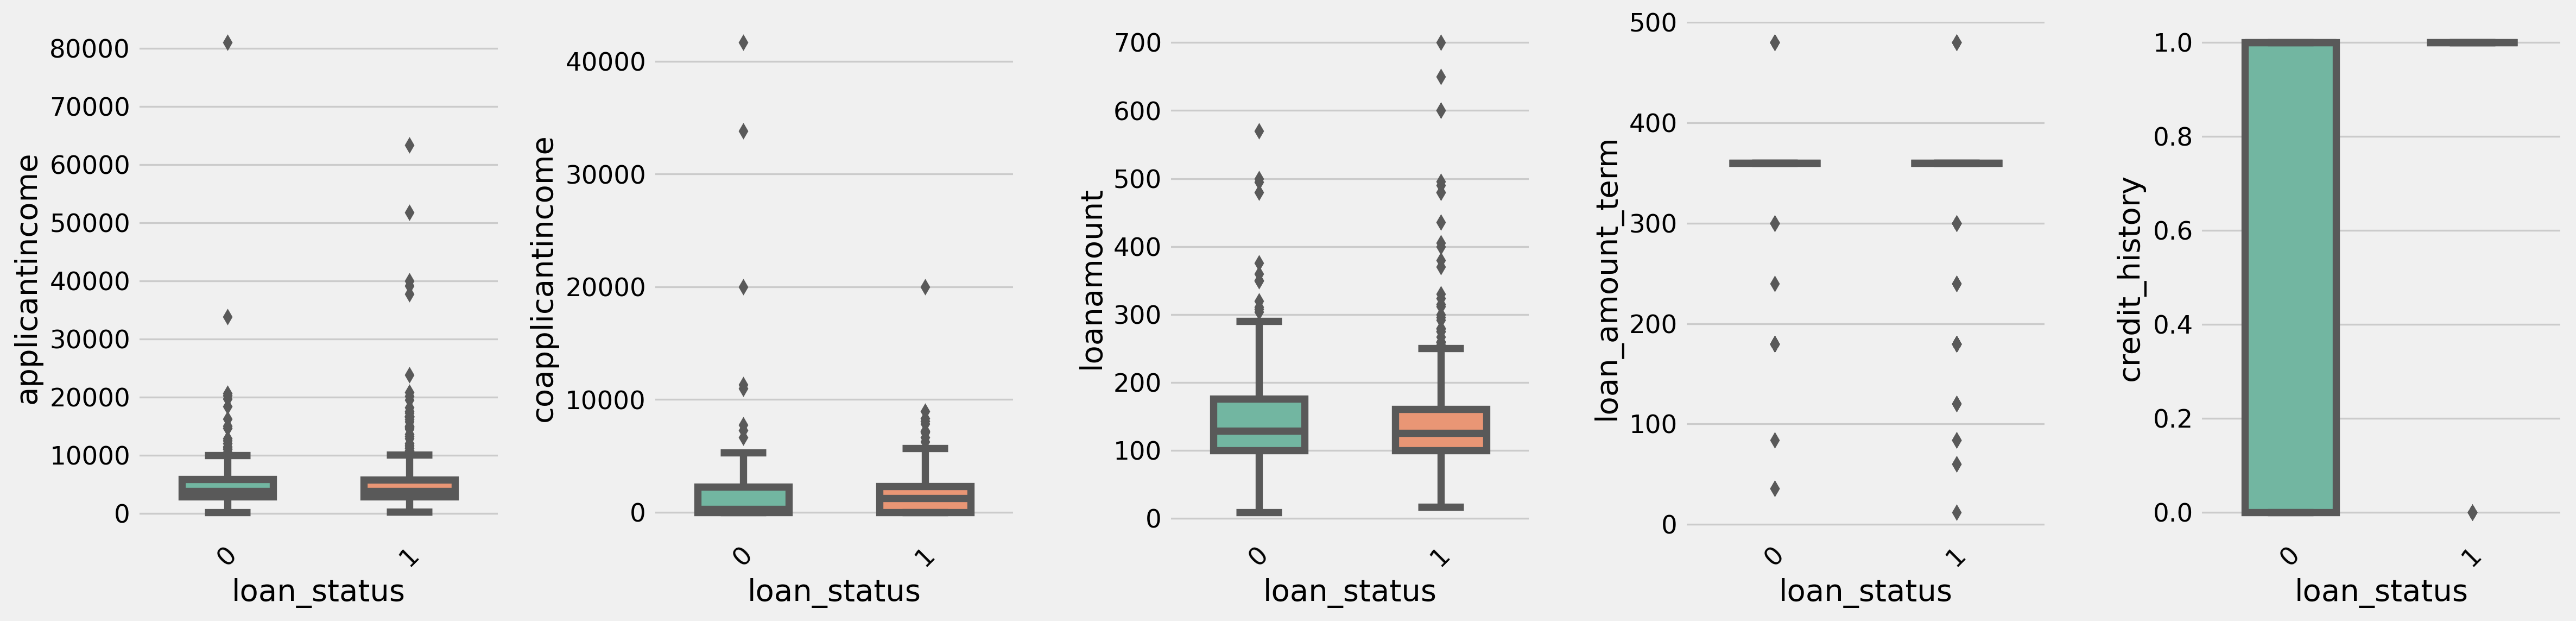

In [93]:
# box plot continuous features for outliers spotting / high prediction importance ("if they do not overlap"?)
c_map = sns.color_palette("Set2")

fig, axes = plt.subplots(ncols=5, figsize=(20, 5))
for i, ax in enumerate(axes):
    sns.boxplot(x=df_analysis["loan_status"], y=continuous_fts[i], data=df_analysis[continuous_fts], palette=c_map, width=0.5, ax=ax)

# rotate x-axis for every single plot
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

# set spacing for every subplot, else x-axis will be covered
plt.tight_layout()

# export report figure
plt.savefig("../reports/eda/num_ftr_boxplt_outliers.png")

## Target frequency

1    68.729642
0    31.270358
Name: loan_status, dtype: float64


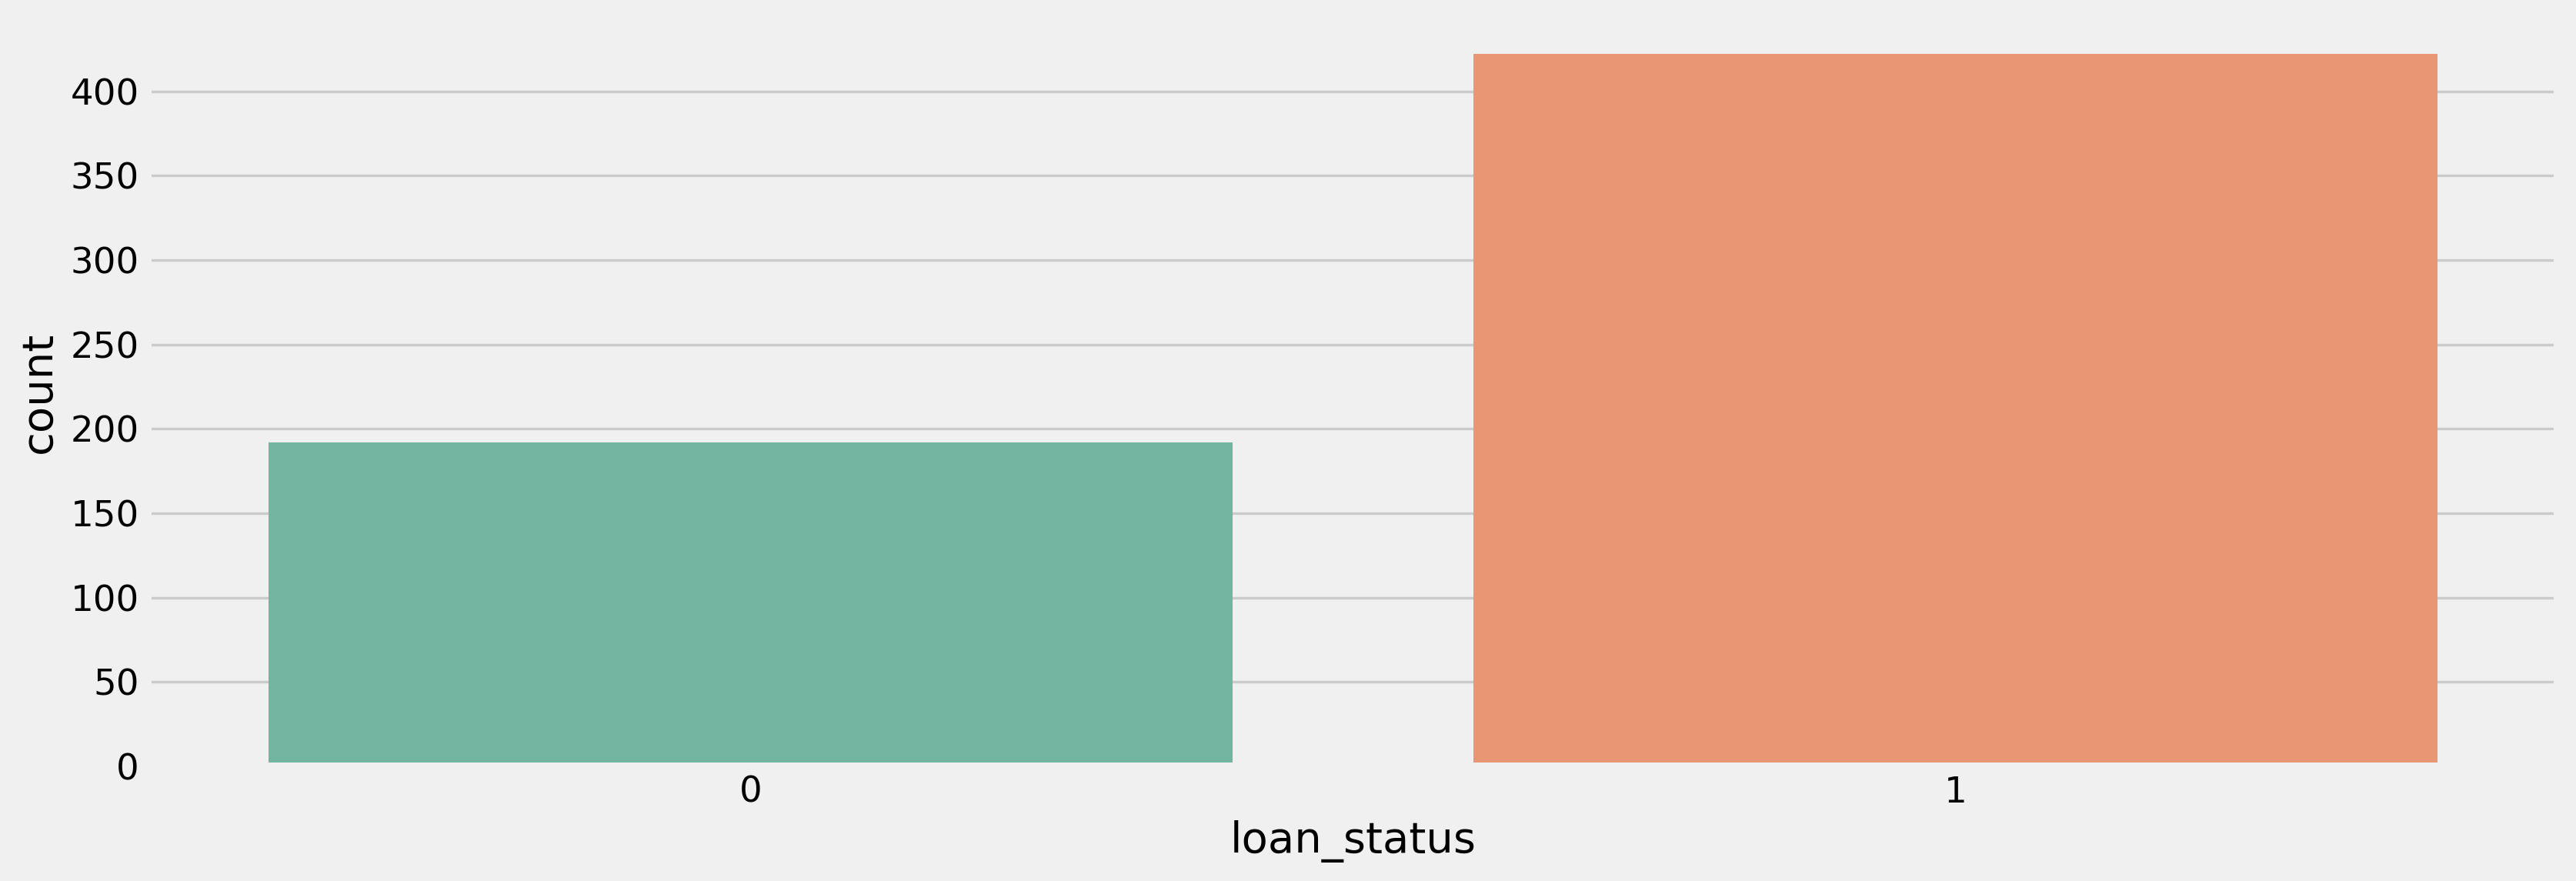

In [95]:
# count plot target feature distribution
sns.countplot(df_analysis["loan_status"], palette=c_map)
print(df_analysis["loan_status"].value_counts() / len(df_analysis["loan_status"]) * 100)

# export report figure
plt.savefig("../reports/eda/target_frequency.png")

## Multivariate analysis

### Correlation

In [99]:
# encode categorical features for heatmap plotting
for col in categorical_fts:
    df_analysis[col] = LabelEncoder().fit_transform(df_analysis[col])
    df_analysis[col].unique()

In [106]:
# heatmap plot features -> target correlation
sns.heatmap(df_analysis.corr()[["loan_status"]].sort_values("loan_status").tail(10), vmax=1, vmin=-1, cmap=c_map, annot=True, ax=ax);

<Figure size 1800x600 with 0 Axes>

# Model building

## Data preprocessing 

In [30]:
# Drop obselete column 
df_train = df_train.drop(["Loan_ID"], axis=1)

In [31]:
# Preprocess data before model instantiation
df_train = df_train.dropna()
df_test = df_test.dropna()

In [32]:
df_train.columns = df_train.columns.str.lower()
df_test.columns = df_test.columns.str.lower()

In [33]:
df_train["dependents"] = pd.to_numeric(df_train["dependents"].map({"3+": "3", "0": "0", "1": "1", "2": "2"}))
df_test["dependents"] = pd.to_numeric(df_test["dependents"].map({"3+": "3", "0": "0", "1": "1", "2": "2"}))

In [15]:
class MultiColumnLabelEncoder(LabelEncoder):
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        """
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        """
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = super().fit_transform(output[col]).reshape(-1, 1)
        else:
            for colname,col in output.iteritems():
                output[colname] = super().fit_transform(col).reshape(-1, 1)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [34]:
# Features / target split
categorical_fts = [
    "gender", "married", "education", "self_employed",
    "credit_history", "property_area"
]

numerical_fts = ['dependents', 'applicantincome', 'coapplicantincome', 'loanamount', 'loan_amount_term']

In [13]:
def preprocessor(data, num_fts, ctg_fts):
    le = LabelEncoder()

    X_train = data.drop(["loan_status"], axis=1)
    y_train = data["loan_status"]

    X_train[num_fts] = X_train[num_fts].astype(np.float64)

    onehot_df = pd.get_dummies(X_train[ctg_fts[-1]])

    label_df = MultiColumnLabelEncoder(columns = ctg_fts[:-1]).fit_transform(X_train)
    # label_df = label_df.drop([""])
    # X_train = MultiColumnLabelEncoder(columns = ctg_fts[:-1]).fit_transform(X_train)
    label_df = label_df.drop(ctg_fts[-1], axis=1)

    X = label_df.join(onehot_df)
    y = le.fit_transform(y_train)

    return X, y

In [288]:
column_transformer = ColumnTransformer(
    transformers=[
        ("label_encoder", MultiColumnLabelEncoder(), ["gender", "married", "education", "self_employed", "credit_history"]),
        ("onehot_encoder", OneHotEncoder(), ["property_area"]),  # adjusts data to the same scale
        ("scaler", StandardScaler(), numerical_fts)  # adjusts data to the same scale
    ], 
    remainder="passthrough")

logistic_pipeline = imbpipeline([
    ("datafeed", column_transformer),  
    ("SMOTE", SMOTE()),
    # ("selector", SelectKBest(f_classif, k="all")),
    ("classifier", LogisticRegression())
])

In [122]:
column_transformer = ColumnTransformer([
    ("scaler", StandardScaler(), numerical_fts)  # adjusts data to the same scale
], remainder="passthrough")

logistic_pipeline = Pipeline([
    ("datafeed", column_transformer),              # grabs finalized datasets
    ("selector", SelectKBest(f_classif, k="all")), # variable selection procedure
    ("classifier", LogisticRegression())           # Logistic modeling
])

In [123]:
X, y = preprocessor(df_train, numerical_fts, categorical_fts)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [124]:
sm = SMOTE(random_state=0)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
X_test_sm, y_test_sm = sm.fit_resample(X_test, y_test)

## Model instantiation

In [75]:
logistic_pipeline.fit(X_train, y_train) 

Pipeline(steps=[('datafeed',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['dependents',
                                                   'applicantincome',
                                                   'coapplicantincome',
                                                   'loanamount',
                                                   'loan_amount_term'])])),
                ('classifier',
                 LogisticRegression(C=2.483697553131913, fit_intercept=0,
                                    solver='newton-cg',
                                    tol=5.5748629308865946e-05,
                                    warm_start=1))])

In [290]:
joblib.dump(logistic_pipeline["classifier"], '../models/clf_model.joblib')

['../models/clf_model.joblib']

## Performance checking

In [77]:
y_pred = logistic_pipeline.predict(X_test_sm)
y_probas = logistic_pipeline.predict_proba(X_test_sm)

In [ ]:
# sm = SMOTE(random_state=0)
# X_test, y_test = sm.fit_resample(X_test, y_test)
# X_test = column_transformer.inverse_transform(X_test)

X_test = logistic_pipeline["datafeed"].fit_transform(X_test)
X_test_sm, y_test_sm = logistic_pipeline["SMOTE"].fit_resample(X_test, y_test)
# X_test = logistic_pipeline["datafeed"].inverse_transform(X_test)

y_pred = logistic_pipeline.predict(X_test_sm)
y_probas = logistic_pipeline.predict_proba(X_test_sm)

In [123]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


# title = "Learning Curves (Logistic Regression)"
# # Cross validation with 50 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=50, test_size=0.3, random_state=0)

# plot_learning_curve(
#     logistic_pipeline["classifier"], title, X, y, axes=None, ylim=(0.7, 1.01), cv=cv, n_jobs=-1
# )

# plt.show()

In [22]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories="auto",
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap="Blues",
                          title=None):
    """
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is "auto"
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show "True Label" and "Predicted Label" on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is "Blues"
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    """


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ["" for _ in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = [f"{value}\n" for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f} - Precision={:0.3f}\nRecall={:0.3f} - F1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize is None:
        #Get default figure size if not set
        figsize = plt.rcParams.get("figure.figsize")

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel("True label")
        plt.xlabel(f"Predicted label{stats_text}")
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

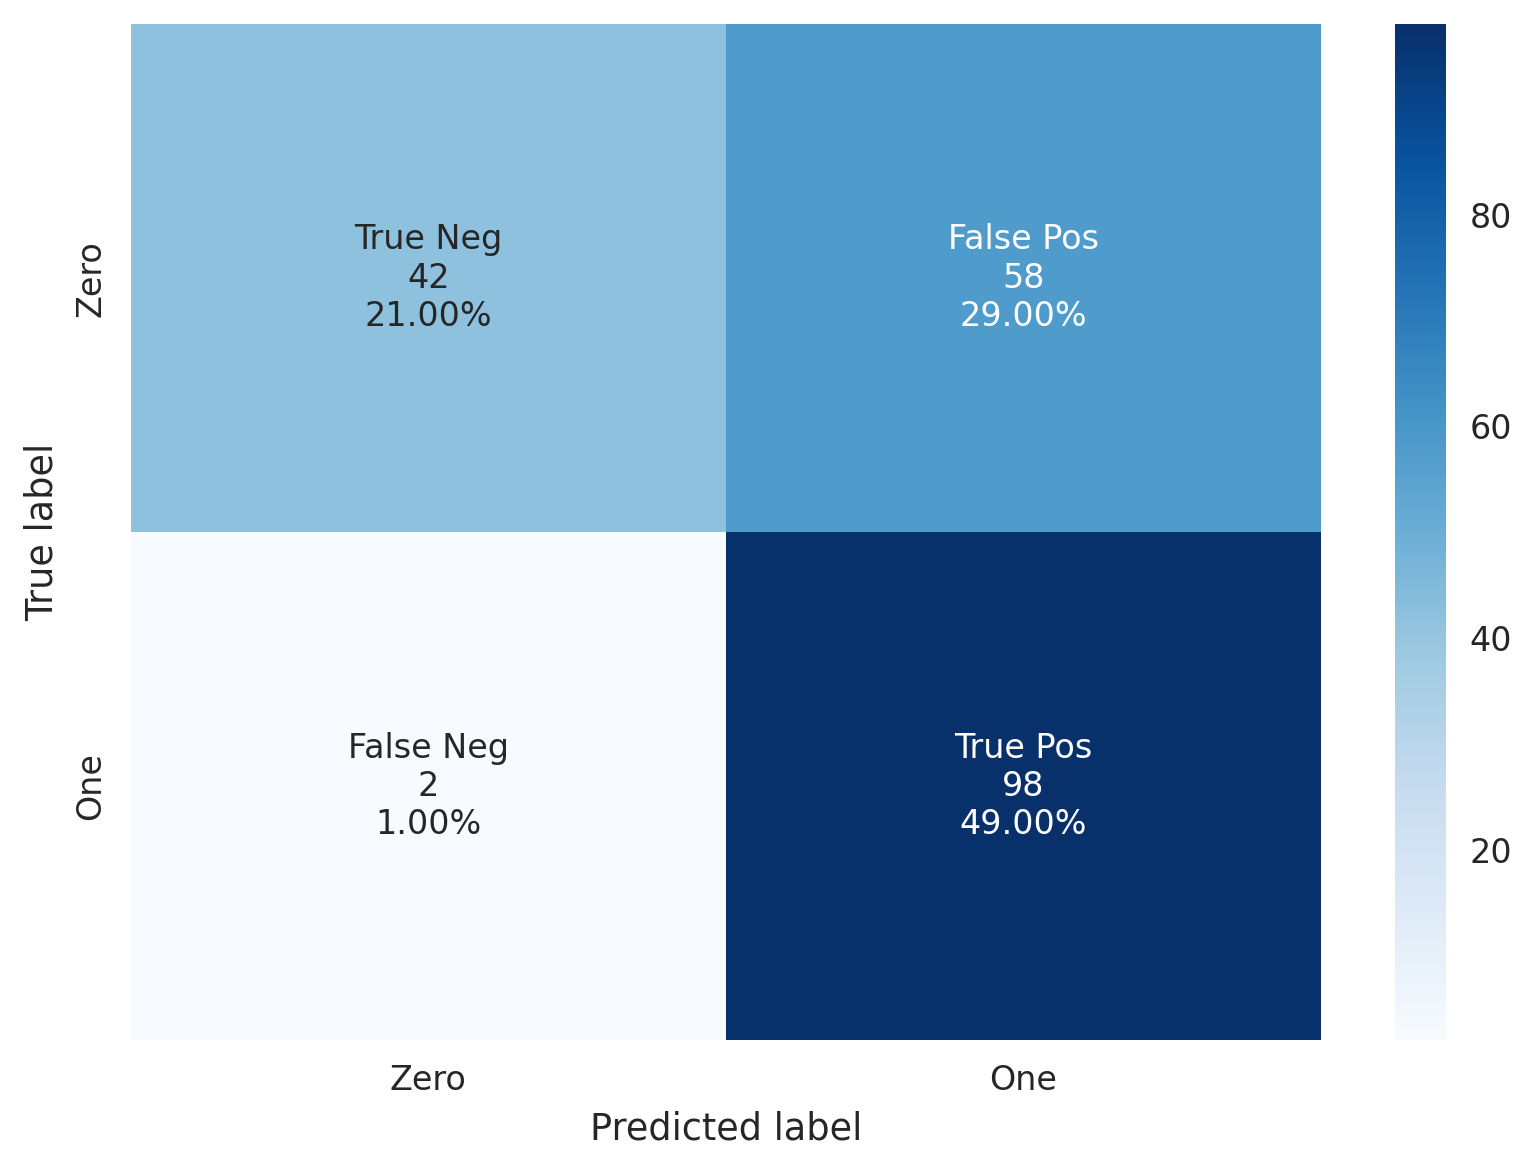

In [78]:
# _, y_test = logistic_pipeline[:-1].fit_resample(X_test, y_test)
cf_matrix = confusion_matrix(y_test_sm, y_pred)

group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
categories = ["Zero", "One"]
make_confusion_matrix(cf_matrix, 
                      group_names=group_names,
                      categories=categories, sum_stats=None)               

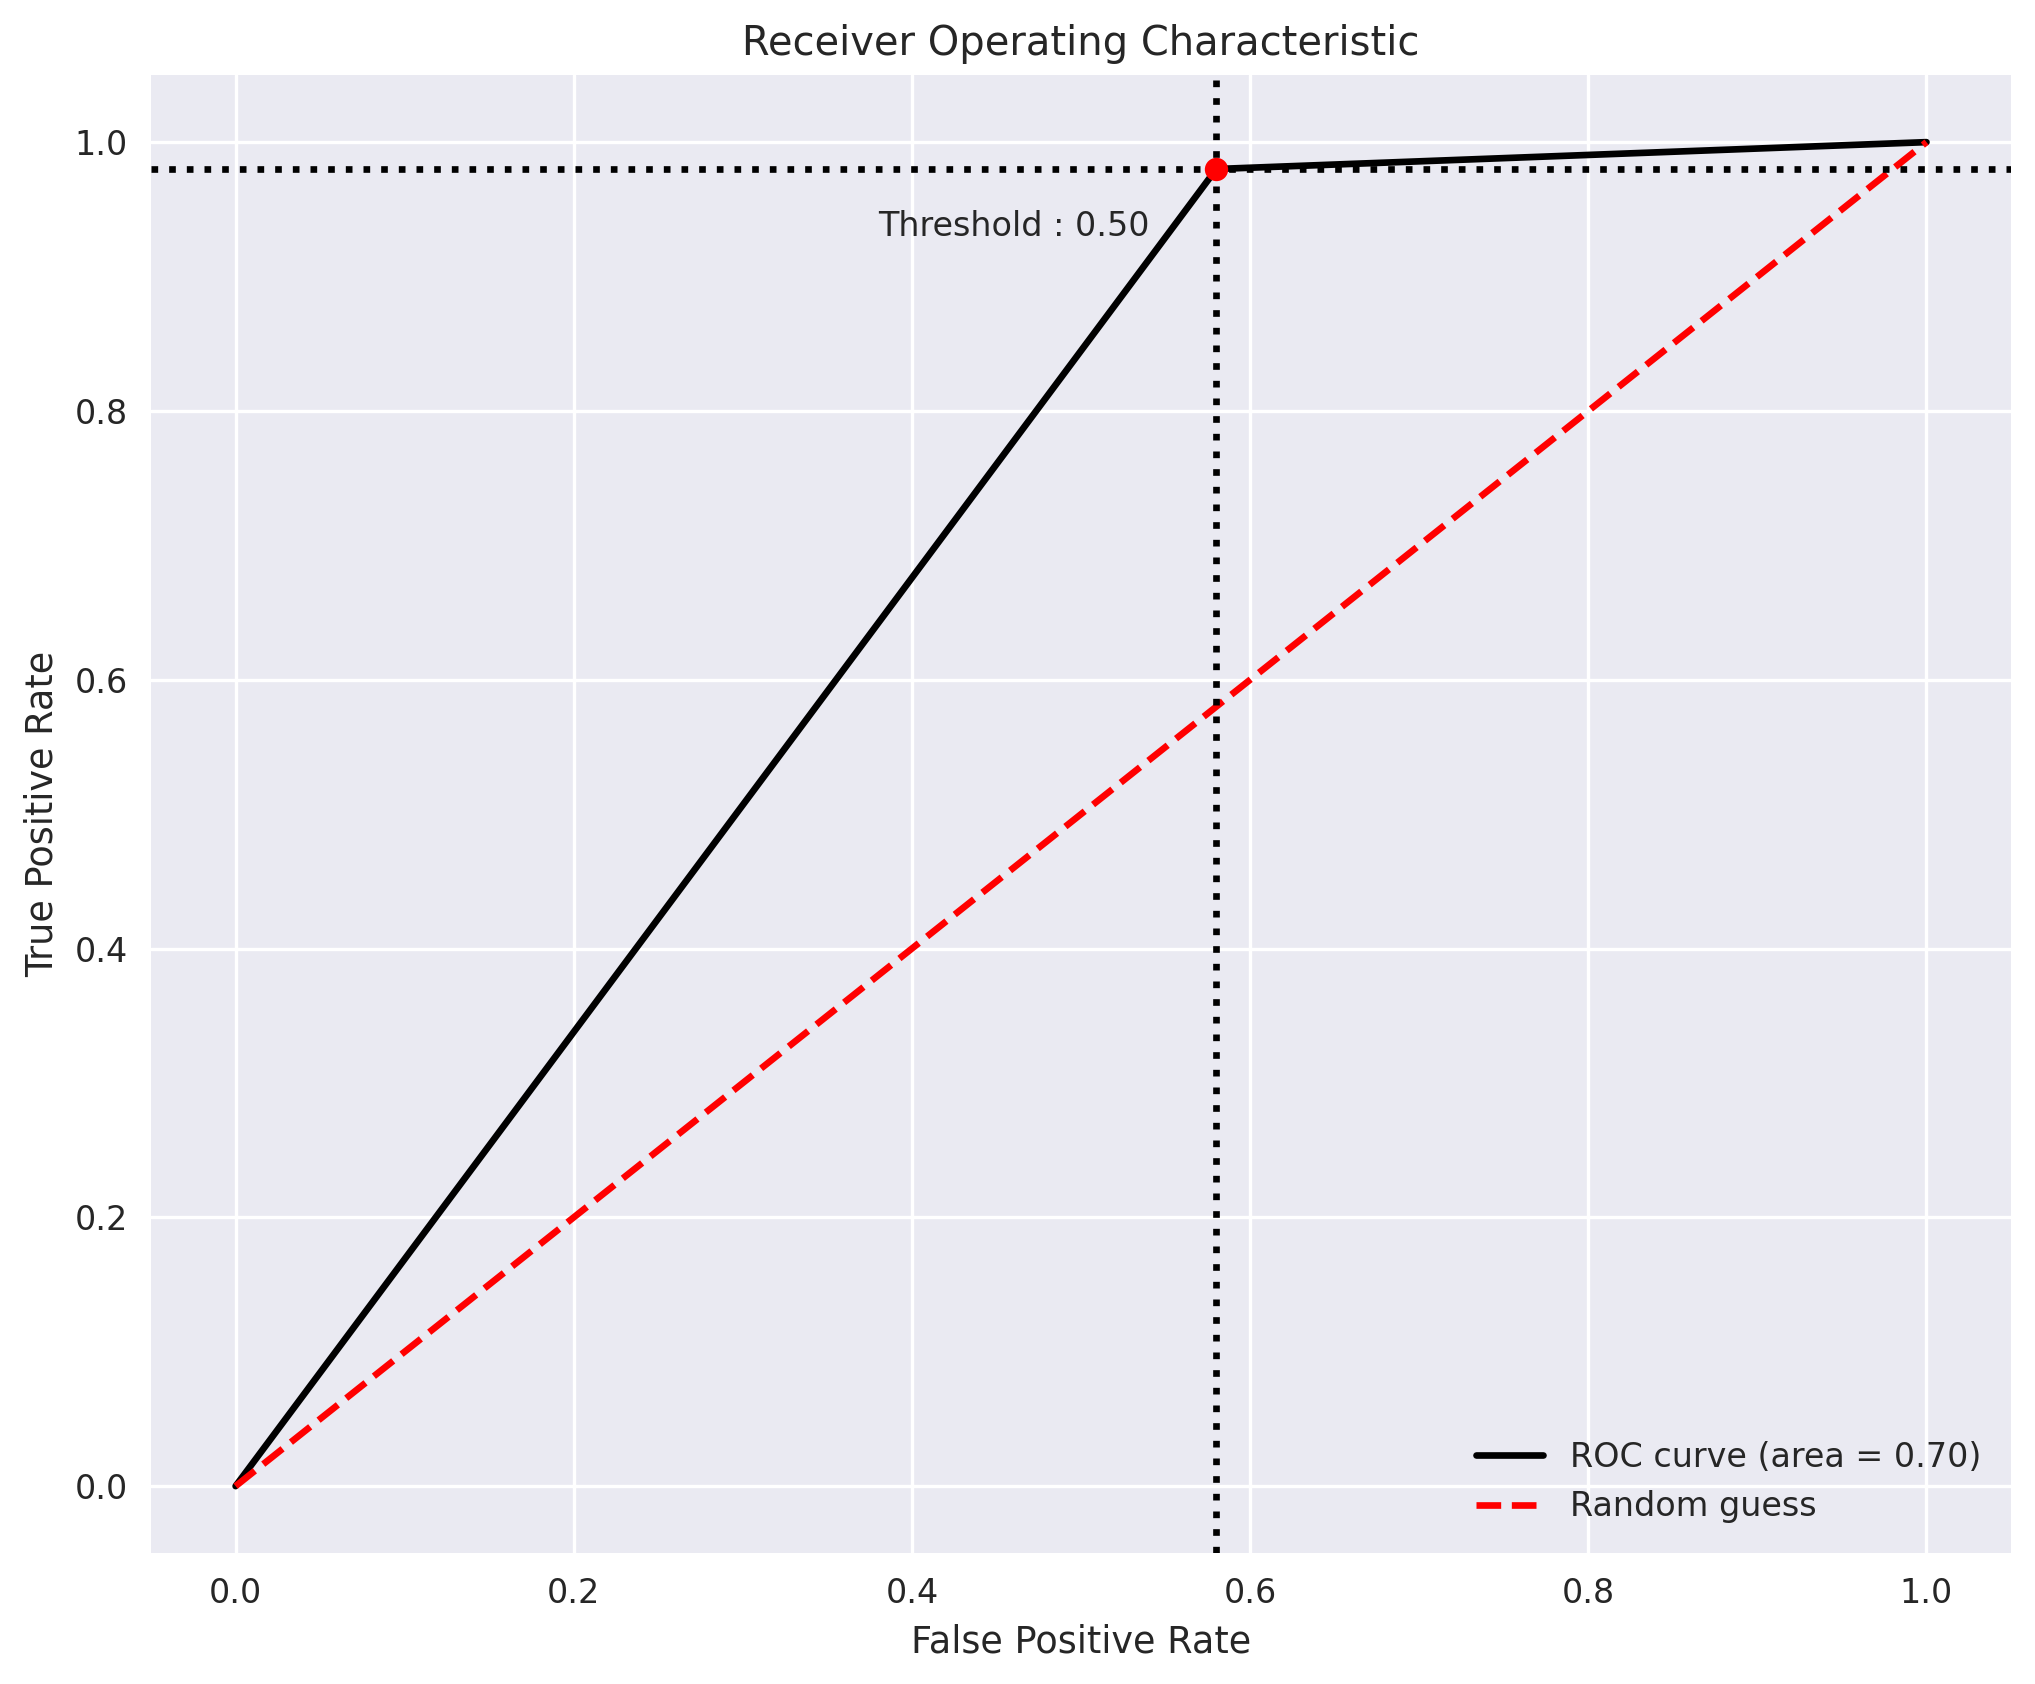

In [140]:
bc = BinaryClassification(y_test_sm, y_pred, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(10,8))
bc.plot_roc_curve()
plt.show()

<AxesSubplot: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

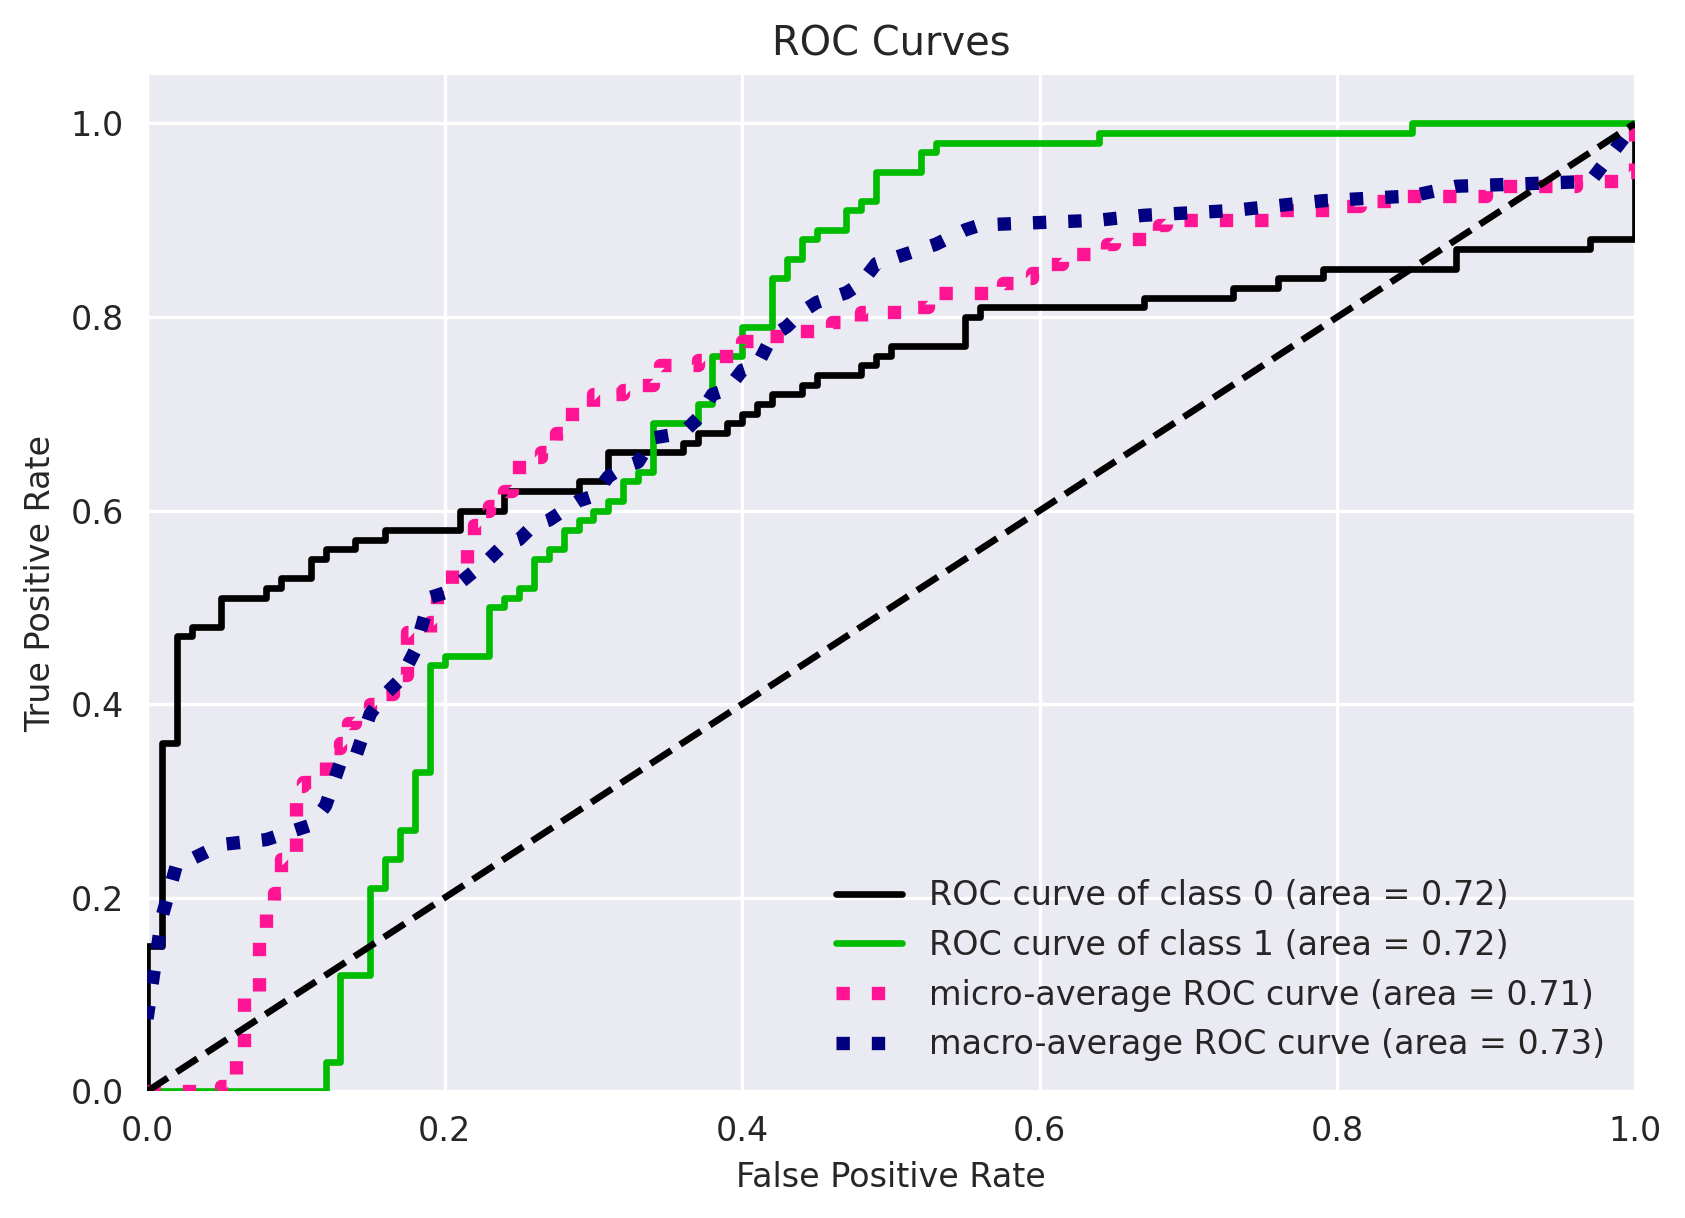

In [165]:
skplt.metrics.plot_roc(y_test_sm, y_probas)

In [80]:
print(classification_report(y_test_sm, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.42      0.58       100
           1       0.63      0.98      0.77       100

    accuracy                           0.70       200
   macro avg       0.79      0.70      0.67       200
weighted avg       0.79      0.70      0.67       200



## Model Explainability

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_sm, feature_names = X_train_sm.columns, class_names=["N", "Y"],
                                                   categorical_features = ["gender","married","education","self_employed","credit_history", "Rural", "Semiurban", "Urban"], 
                                                   categorical_names = ["gender","married","education","self_employed","credit_history", "Rural", "Semiurban", "Urban"], 
                                                   verbose=False)

In [ ]:
X_train_std_sm = logistic_pipeline["datafeed"].fit_transform(X_train_sm)
X_test_std_sm = logistic_pipeline["datafeed"].fit_transform(X_test_sm)

clf = LogisticRegression(n_jobs=-1)
clf.fit(X_train_std_sm, y_train_sm)

y_pred = clf.predict(X_test_std_sm)[0]
predicted_class_idx = list(clf.classes_).index(y_pred)

# Define object that can calculate shap values
explainer = shap.KernelExplainer(clf, X_train_std_sm)

# Standard scale features test set
# observations = StandardScaler().transform(X_test_sm)

# Calculate Shap values
shap_values = explainer.shap_values(X_test_std_sm)

# load JS lib in notebook
shap.initjs()
shap.force_plot(explainer.expected_value[predicted_class_idx], shap_values[predicted_class_idx], feature_names=X.columns)

/home/adilsmh/.pyenv/versions/simplon/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/adilsmh/.pyenv/versions/simplon/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/adilsmh/.pyenv/versions/simplon/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/adilsmh/.pyenv/versions/simplon/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/adilsmh/.pyenv/versions/simplon/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/adilsmh/.pyenv/vers

Elapsed time to compute the importances: 0.138 seconds


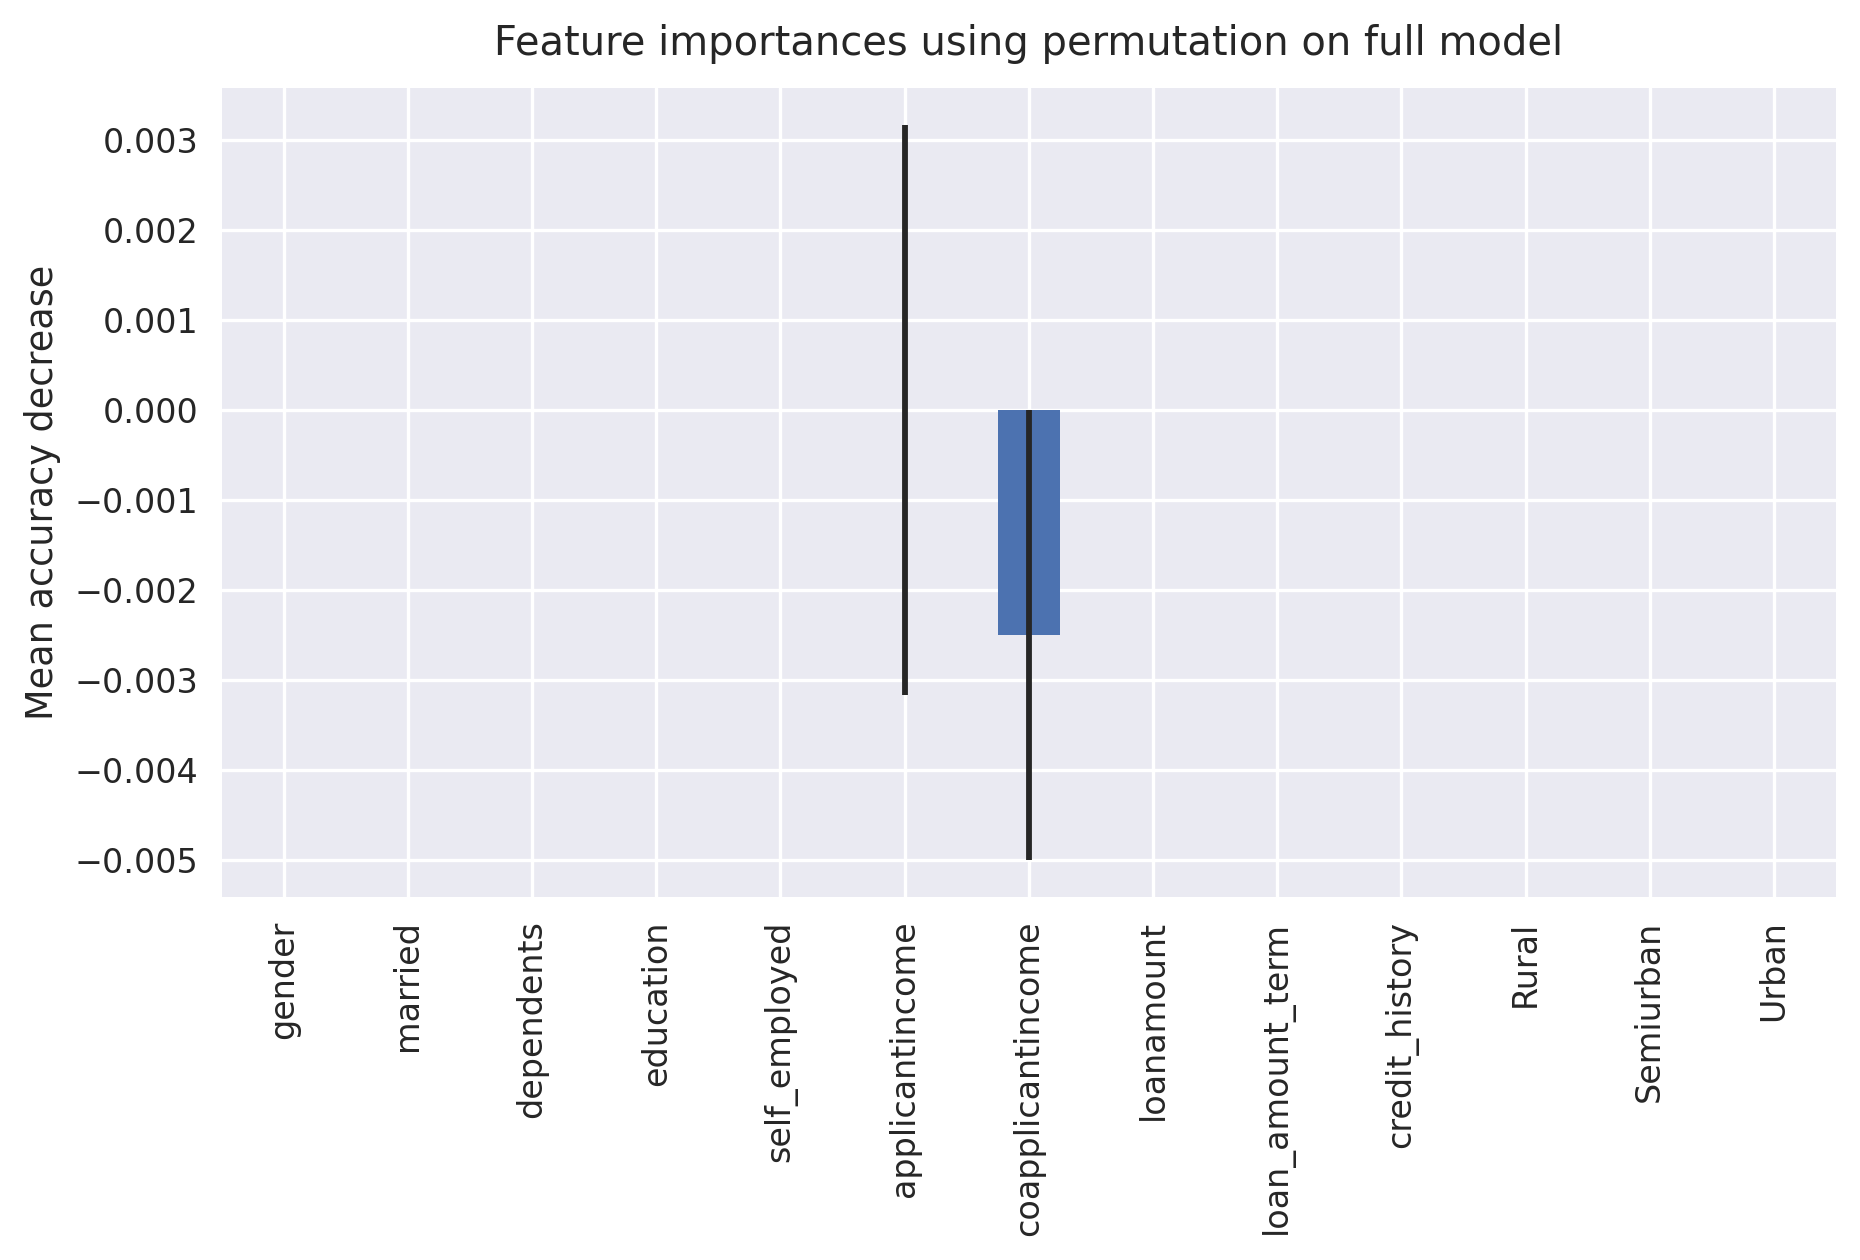

In [427]:
start_time = time.time()
result = permutation_importance(
    logistic_pipeline["classifier"], X_test_sm, y_test_sm, n_repeats=10, random_state=0, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()

forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")

ax.set_ylabel("Mean accuracy decrease")
# ax.set_xlabel(fontsize=22)

fig.tight_layout()
plt.show()

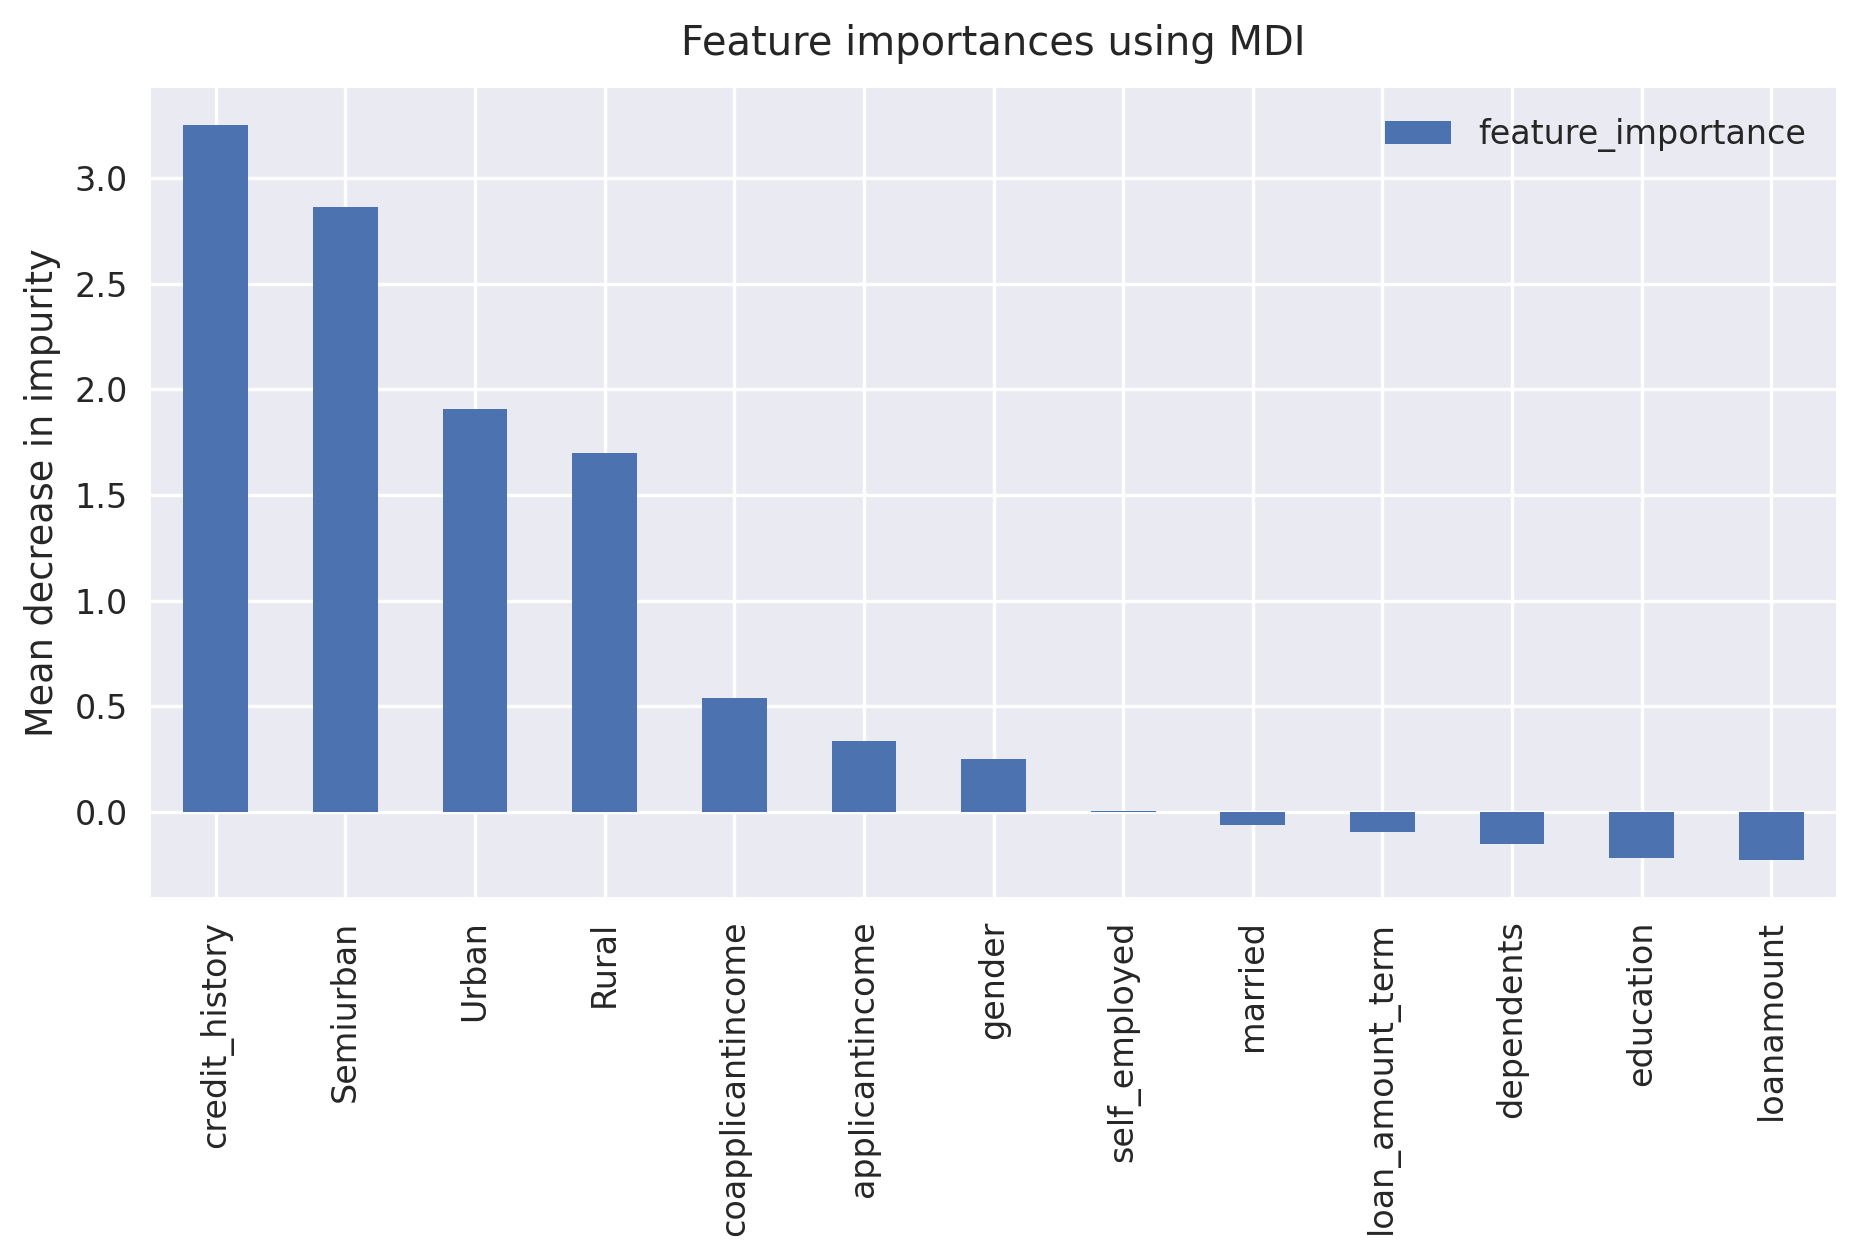

In [403]:
f_impt= pd.DataFrame(np.reshape(logistic_pipeline[-1].coef_, (-1, 1)), index=X.columns)
f_impt = f_impt.sort_values(by=0, ascending=False)
f_impt.columns = ["feature_importance"]

fig, ax = plt.subplots()

f_impt.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
check = TrainTestFeatureDrift()
check.run(X_train_sm, X_test_sm, logistic_pipeline["classifier"], feature_importance_force_permutation=True)

## Feature engineering

In [8]:
# Converting the scale of loan term from months to years
df_train["loan_amount_term_months"] = (df_train["loan_amount_term"] / 12)

In [9]:
# Combining applicant and co-applicant income to get the total income per application
df_train["totalincome"] = df_train["applicantincome"] + df_train["coapplicantincome"]

In [10]:
# Dropping the columns as we created a new column which captures the same information
df_train.drop(columns=["applicantincome", "coapplicantincome"], inplace=True)

In [11]:
# Features / target split
categorical_fts = [
    "gender", "married", "education", "self_employed",
    "credit_history", "property_area"
]

numerical_fts = ['dependents', 'loanamount', 'totalincome', 'loan_amount_term_months']

In [125]:
# Features / target split
categorical_fts = [
    "gender", "credit_history", "property_area"
]

numerical_fts = ['totalincome', 'loanamount', 'loan_amount_term_months']

In [16]:
X, y = preprocessor(df_train, ctg_fts=categorical_fts, num_fts=numerical_fts)

# le = LabelEncoder()

# X = df_train.drop(["loan_status"], axis=1)
# y = le.fit_transform(df_train["loan_status"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [127]:
column_transformer2 = ColumnTransformer(
    transformers=[
        ("label_encoder", MultiColumnLabelEncoder(), categorical_fts),
        ("onehot_encoder", OneHotEncoder(), ["property_area"]),  # adjusts data to the same scale
        ("scaler", StandardScaler(), numerical_fts)  # adjusts data to the same scale
    ], 
    remainder="drop")

# logistic_pipeline = imbpipeline([
#     ("datafeed", column_transformer),  
#     ("SMOTE", SMOTE()),
#     # ("selector", SelectKBest(f_classif, k="all")),
#     ("classifier", LogisticRegression())
# ])

In [128]:
X_train = column_transformer2.fit_transform(X_train)
X_test = column_transformer2.fit_transform(X_test)

In [17]:
sm = SMOTE(random_state=0)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
X_test_sm, y_test_sm = sm.fit_resample(X_test, y_test)

In [18]:
column_transformer2 = ColumnTransformer([
    ("scaler", StandardScaler(), numerical_fts)  # adjusts data to the same scale
], remainder="passthrough")

logistic_pipeline2 = Pipeline([
    ("datafeed", column_transformer2),              # grabs finalized datasets
    # ("selector", SelectKBest(f_classif, k="all")), # variable selection procedure
    ("classifier", LogisticRegression(C= 2.856731708885844, fit_intercept= True, max_iter= 447, penalty= "l2", solver= "liblinear", tol= 1.068168586173638e-05, warm_start= True))
])

In [19]:
logistic_pipeline2.fit(X_train_sm, y_train_sm)

Pipeline(steps=[('datafeed',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['dependents', 'loanamount',
                                                   'totalincome',
                                                   'loan_amount_term_months'])])),
                ('classifier',
                 LogisticRegression(C=2.856731708885844, max_iter=447,
                                    solver='liblinear',
                                    tol=1.068168586173638e-05,
                                    warm_start=True))])

In [20]:
y_pred2 = logistic_pipeline2.predict(X_test_sm)
y_probas2 = logistic_pipeline2.predict_proba(X_test_sm)

In [ ]:
title = "Learning Curves (Logistic Regression)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.3, random_state=0)

plot_learning_curve(
    logistic_pipeline2["classifier"], title, X_train_sm, y_train_sm, axes=None, ylim=(0.7, 1.01), cv=cv, n_jobs=-1
)

plt.show()

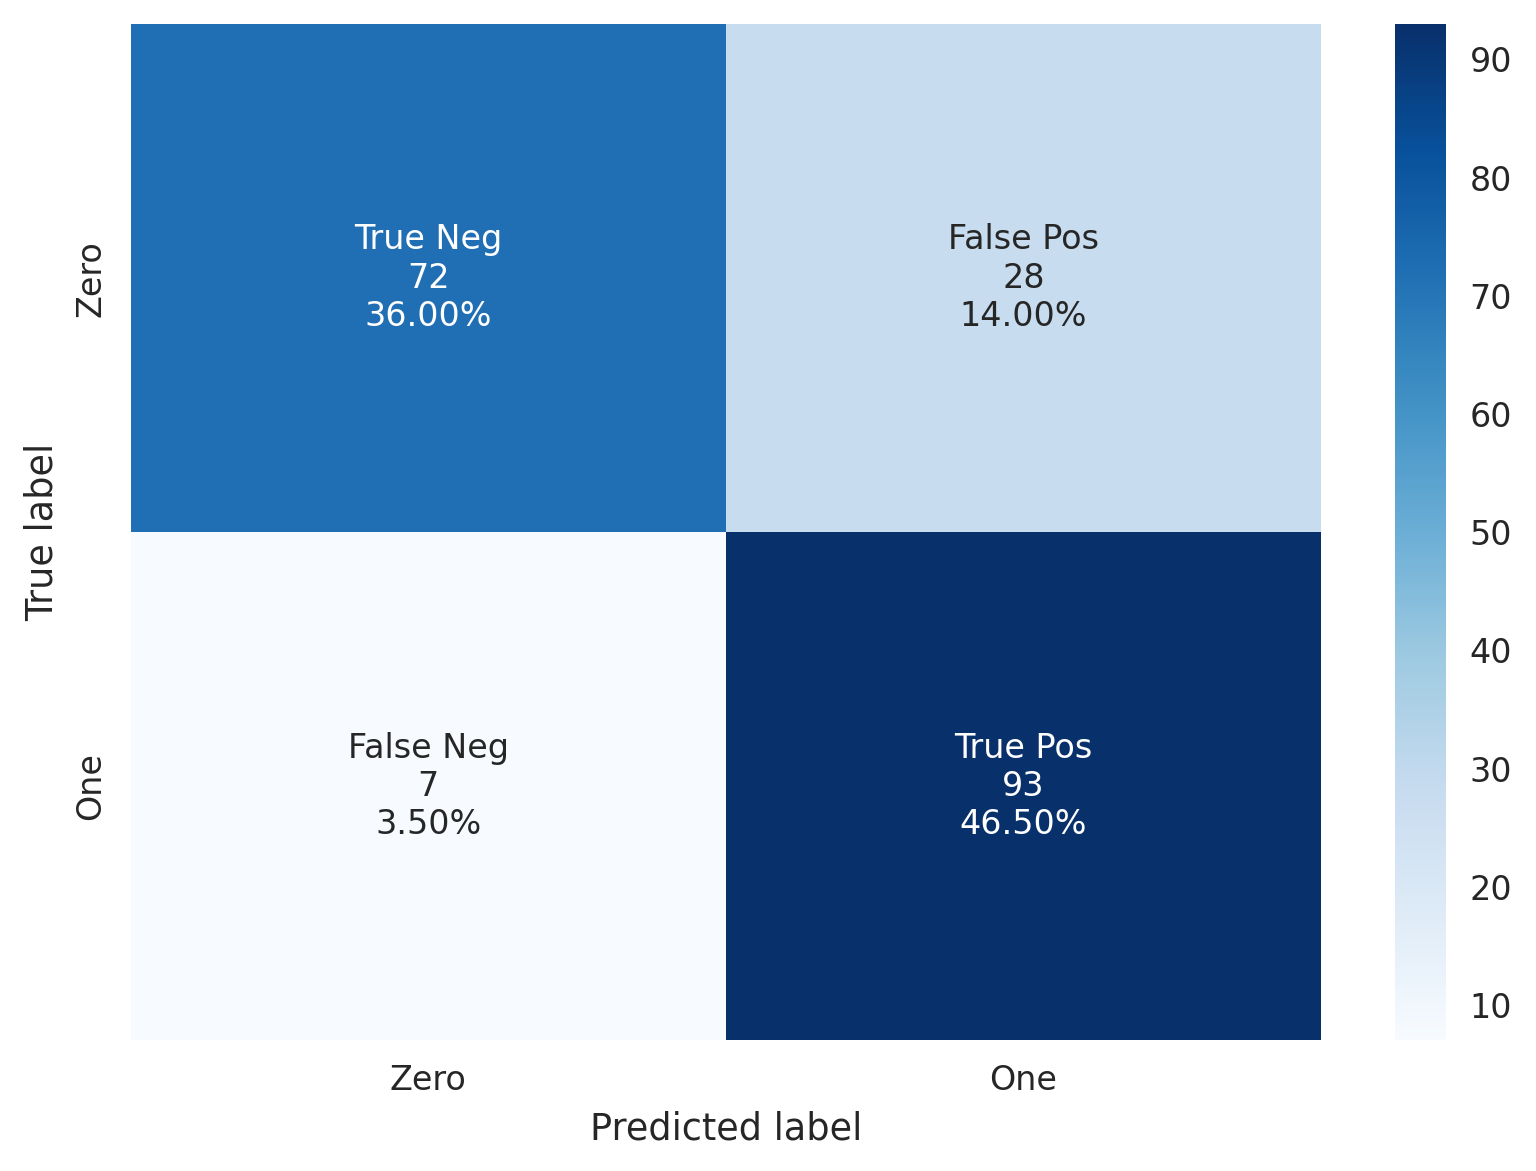

In [23]:
cf_matrix2 = confusion_matrix(y_test_sm, y_pred2)

group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
categories = ["Zero", "One"]
make_confusion_matrix(cf_matrix2, 
                      group_names=group_names,
                      categories=categories, sum_stats=None) 

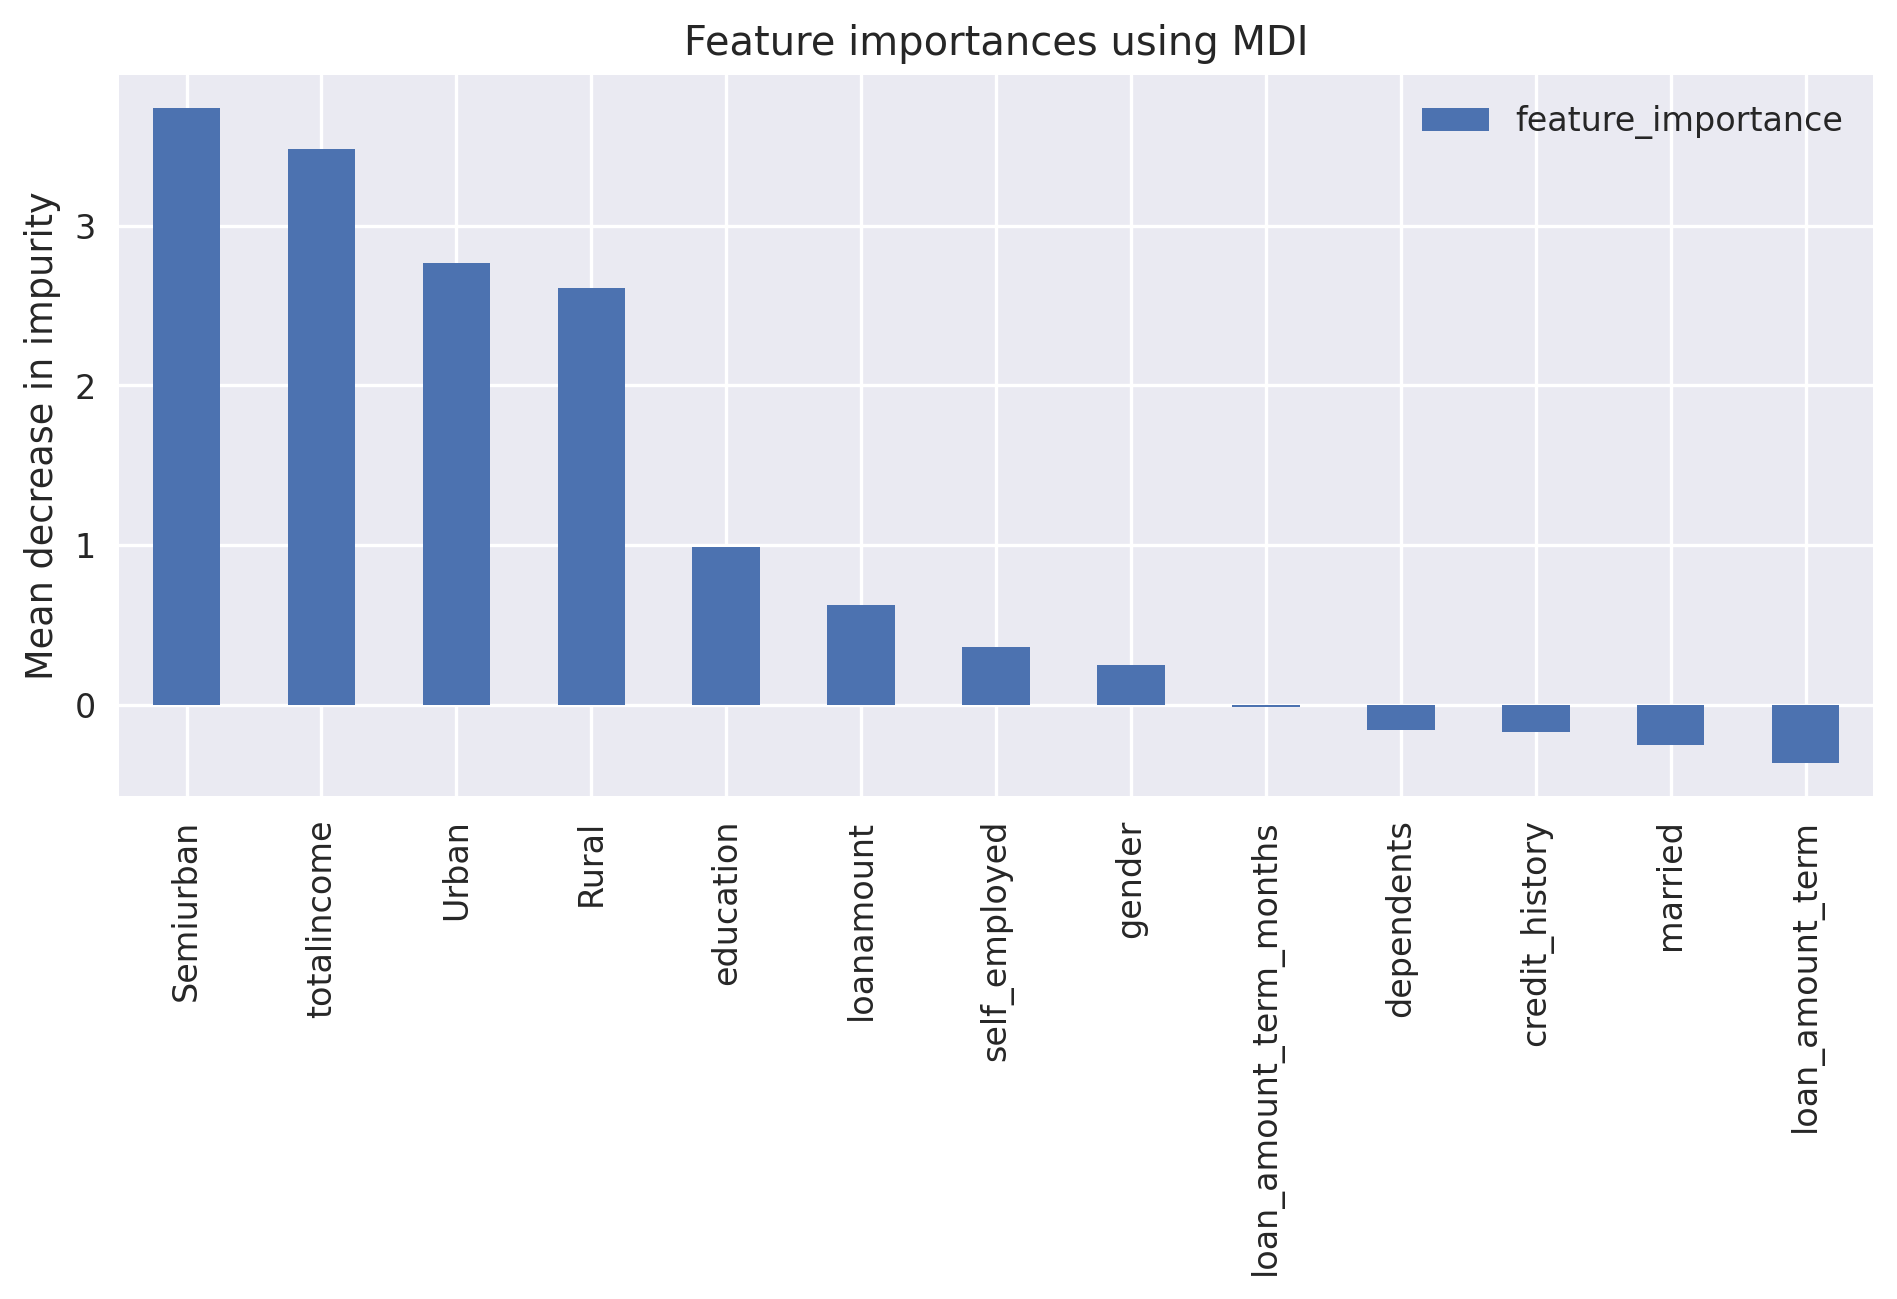

In [24]:
f_impt= pd.DataFrame(np.reshape(logistic_pipeline2[-1].coef_, (-1, 1)), index=X.columns)
f_impt = f_impt.sort_values(by=0, ascending=False)
f_impt.columns = ["feature_importance"]

fig, ax = plt.subplots()

f_impt.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

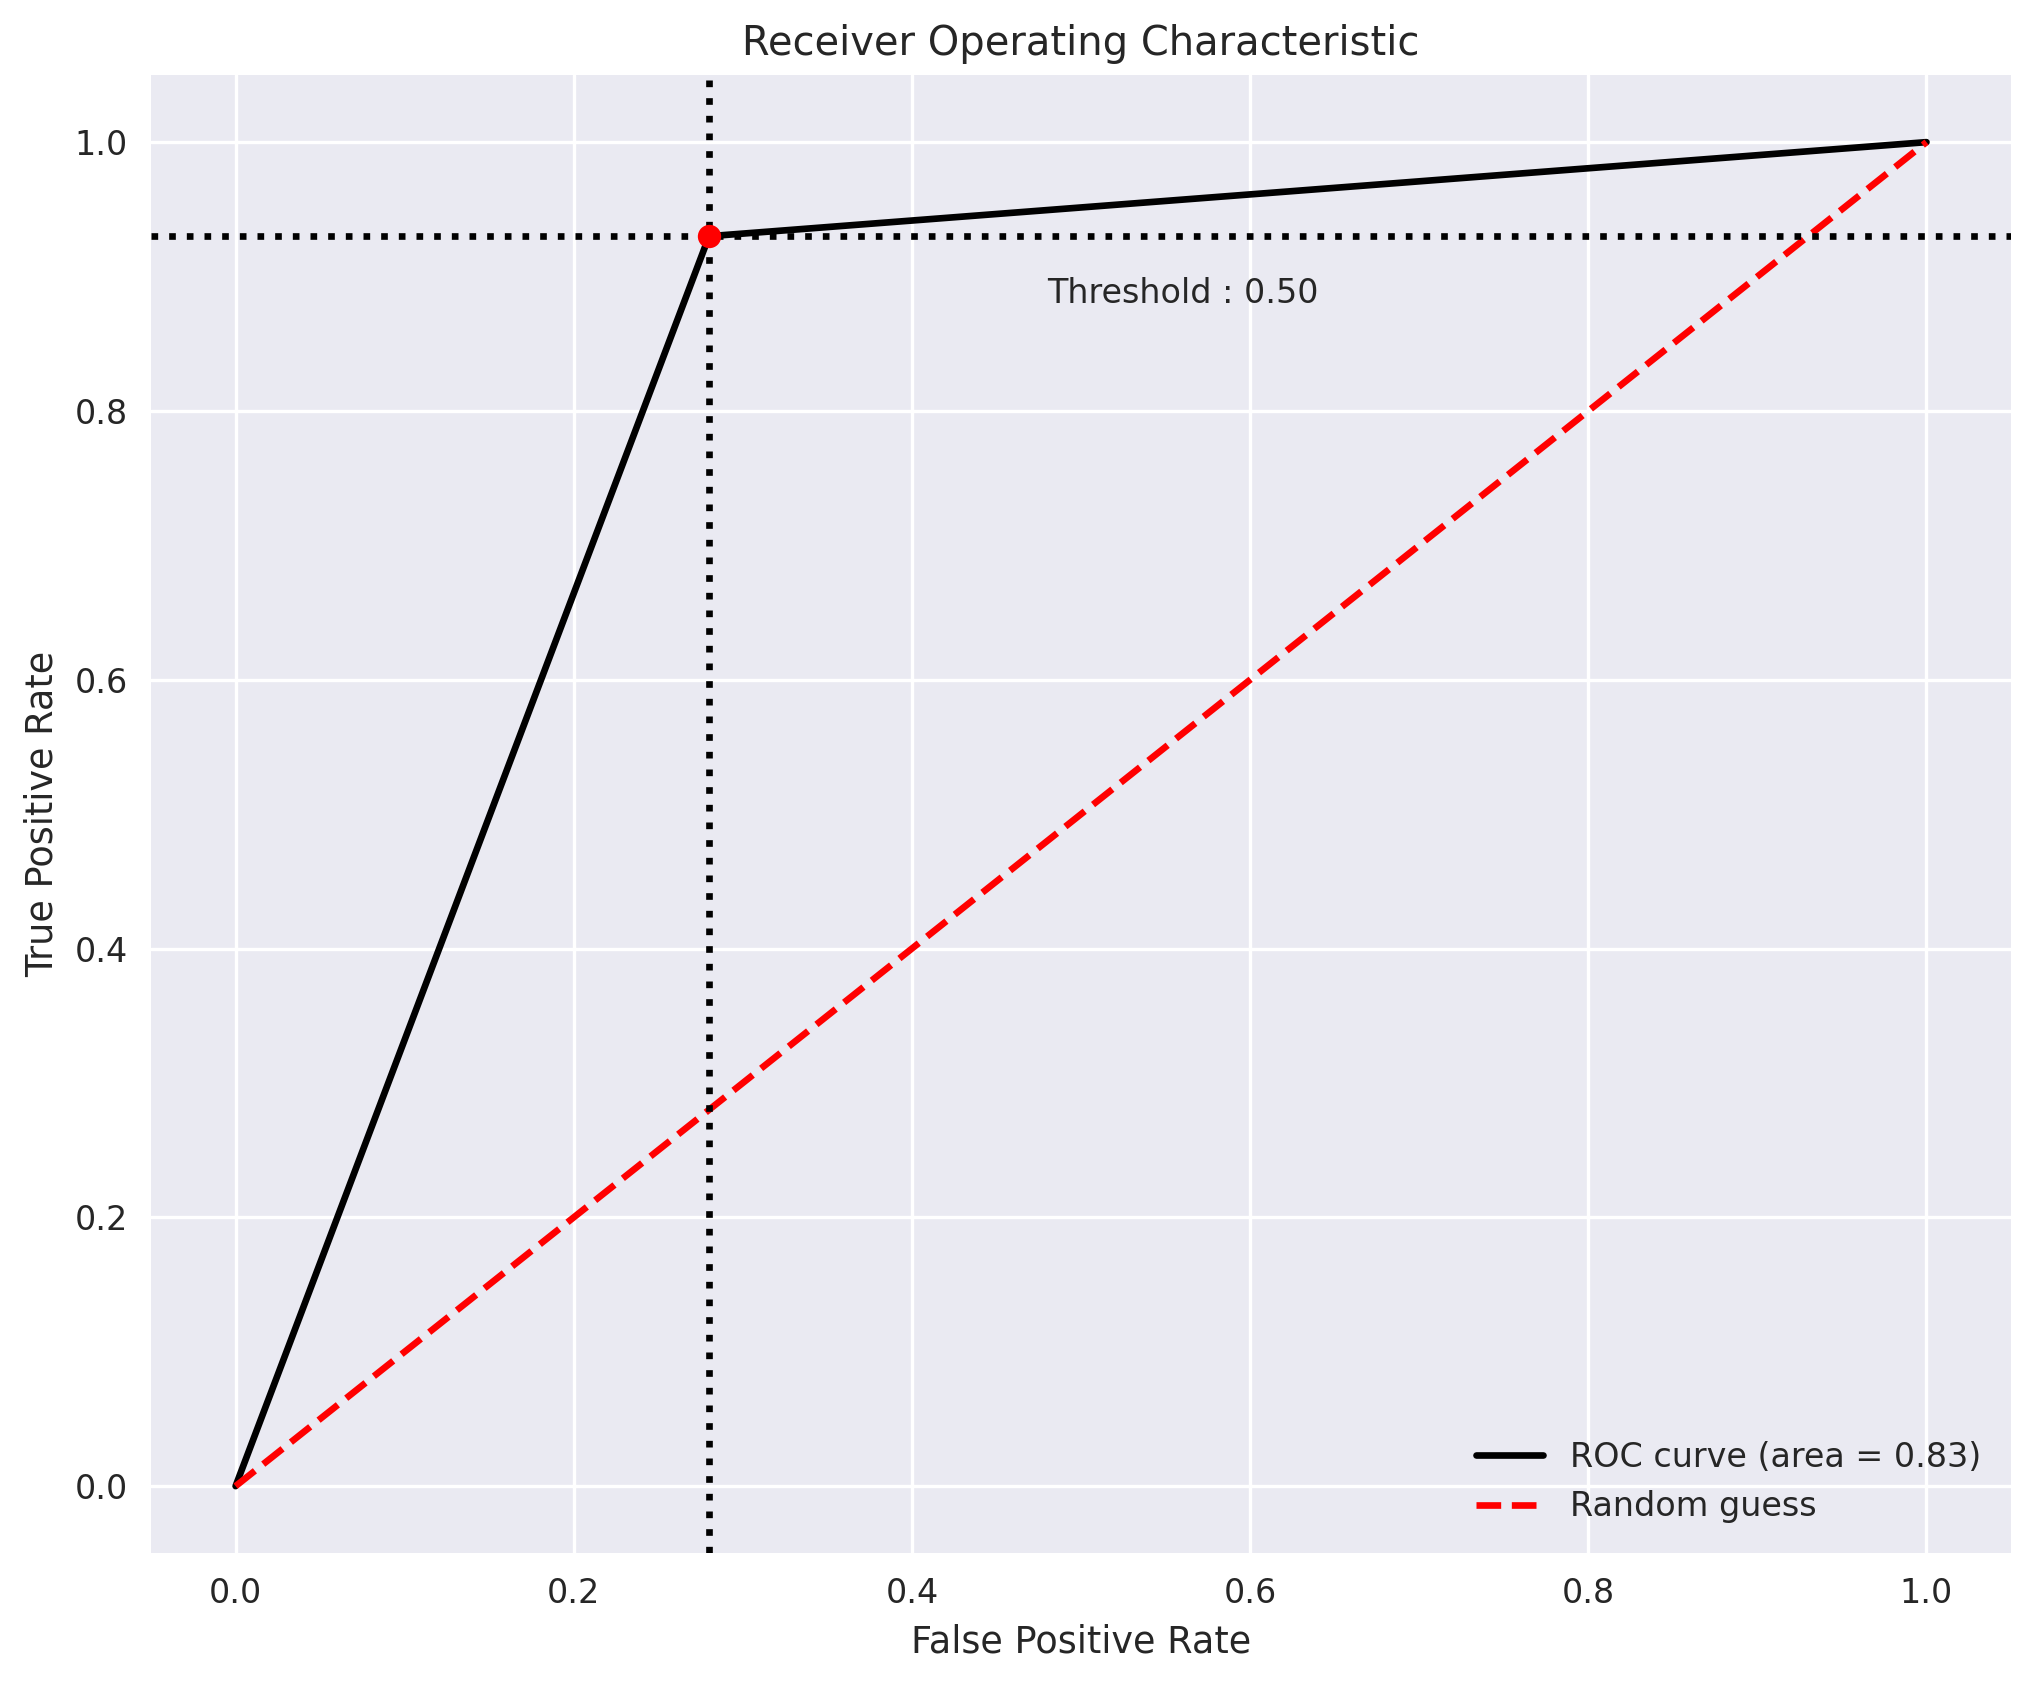

In [27]:
bc = BinaryClassification(y_test_sm, y_pred2, labels=["Class 0", "Class 1"])

# Figures
plt.figure(figsize=(10,8))
bc.plot_roc_curve()
plt.show()

In [28]:
print(classification_report(y_test_sm, y_pred2))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80       100
           1       0.77      0.93      0.84       100

    accuracy                           0.82       200
   macro avg       0.84      0.82      0.82       200
weighted avg       0.84      0.82      0.82       200



## Under-sampling

In [102]:
X, y = preprocessor(df_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [103]:
# cc = ClusterCentroids(random_state=0)
random_us = RandomUnderSampler(random_state=0)

X_train_us, y_train_us = random_us.fit_resample(X_train, y_train)
X_test_us, y_test_us = random_us.fit_resample(X_test, y_test)

In [104]:
column_transformer = ColumnTransformer([
    ("scaler", StandardScaler(), numerical_fts)  # adjusts data to the same scale
], remainder="passthrough")

logistic_pipeline3 = Pipeline([
    ("datafeed", column_transformer),              # grabs finalized datasets
    # ("selector", SelectKBest(f_classif, k="all")), # variable selection procedure
    ("classifier", LogisticRegression())           # Logistic modeling
])

In [105]:
logistic_pipeline3.fit(X_train_us, y_train_us)

Pipeline(steps=[('datafeed',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['dependents', 'loanamount',
                                                   'totalincome',
                                                   'loan_amount_term_months'])])),
                ('classifier', LogisticRegression())])

In [106]:
y_pred3 = logistic_pipeline3.predict(X_test_us)
y_probas3 = logistic_pipeline3.predict_proba(X_test_us)

/home/adilsmh/.pyenv/versions/simplon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/adilsmh/.pyenv/versions/simplon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

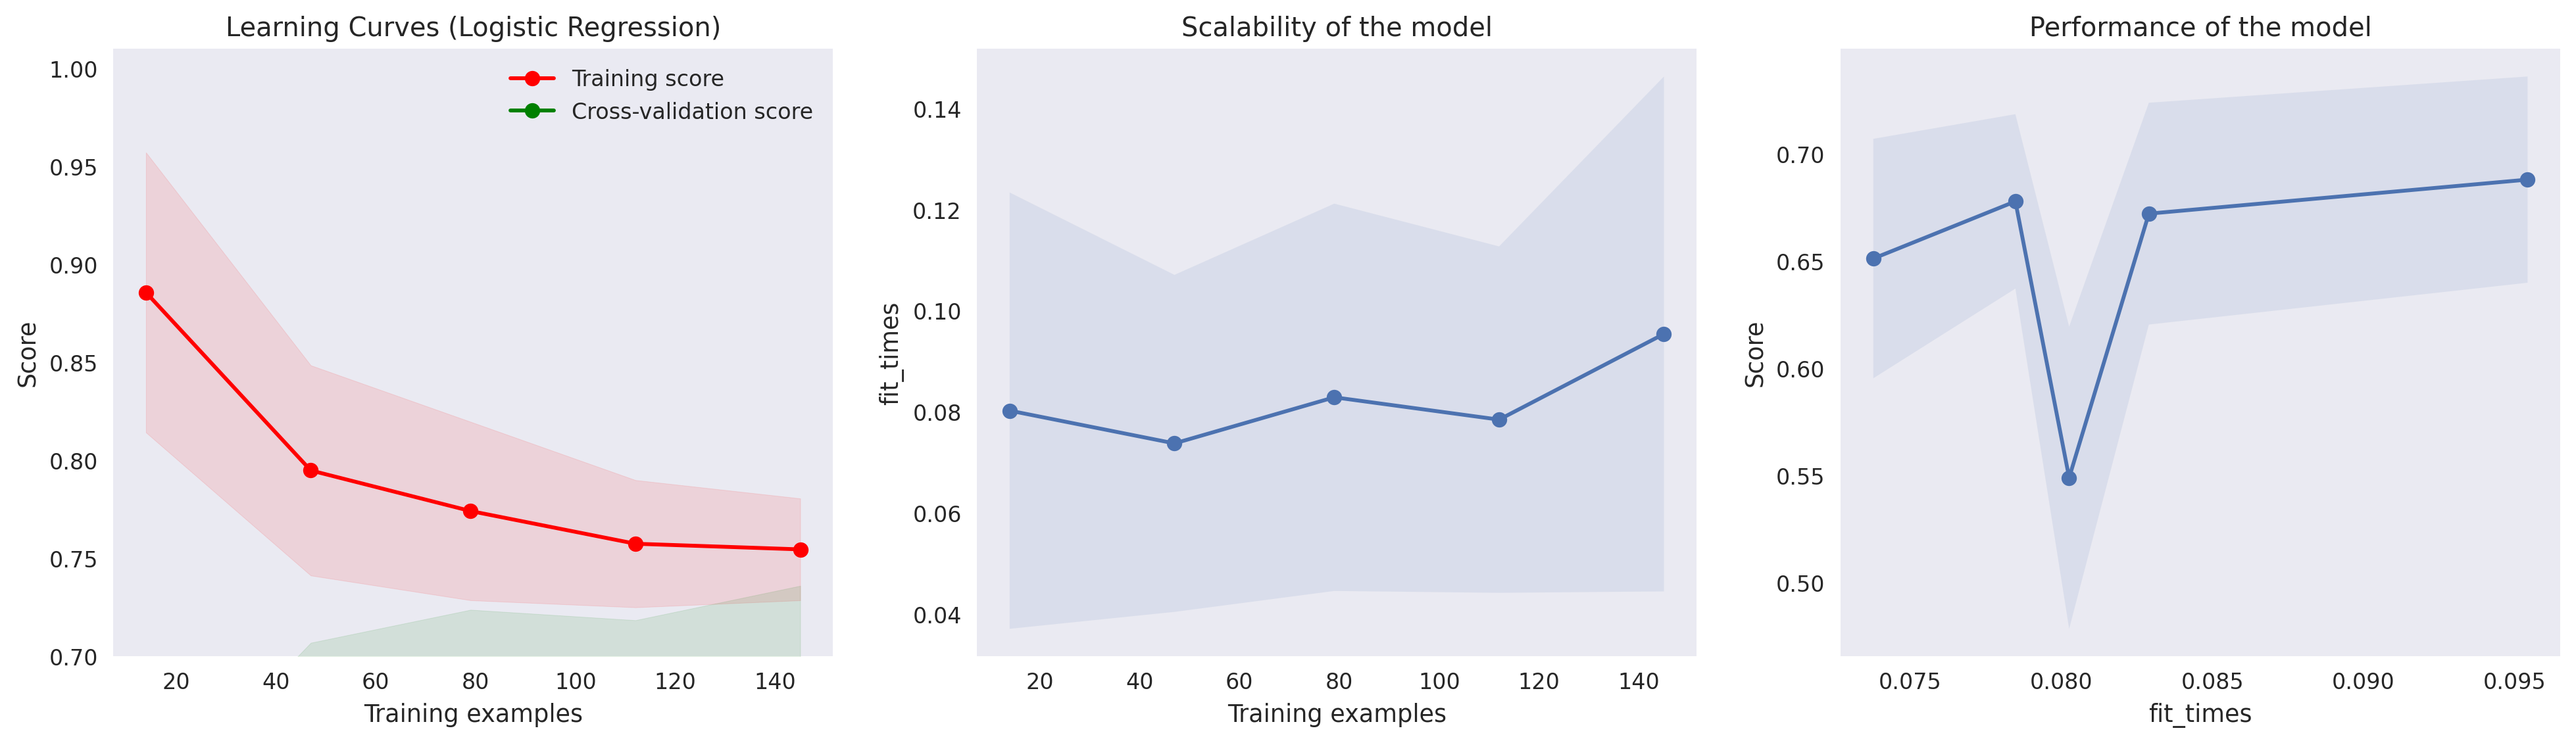

In [124]:
title = "Learning Curves (Logistic Regression)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.3, random_state=0)

plot_learning_curve(
    logistic_pipeline3["classifier"], title, X_train_us, y_train_us, axes=None, ylim=(0.7, 1.01), cv=cv, n_jobs=-1
)

plt.show()

In [ ]:
cf_matrix3 = confusion_matrix(y_test_us, y_pred3)

group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
categories = ["Zero", "One"]
make_confusion_matrix(cf_matrix3, 
                      group_names=group_names,
                      categories=categories, sum_stats=None) 

In [111]:
print(classification_report(y_test_us, y_pred3))

              precision    recall  f1-score   support

           0       0.67      0.55      0.60        44
           1       0.62      0.73      0.67        44

    accuracy                           0.64        88
   macro avg       0.64      0.64      0.63        88
weighted avg       0.64      0.64      0.63        88



## Over/Under-sampling combination

In [113]:
X, y = preprocessor(df_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [115]:
smote_enn = SMOTEENN(random_state=0, n_jobs=-1)

X_train_enn, y_train_enn = smote_enn.fit_resample(X_train, y_train)
X_test_enn, y_test_enn = smote_enn.fit_resample(X_test, y_test)

In [116]:
column_transformer = ColumnTransformer([
    ("scaler", StandardScaler(), numerical_fts)  # adjusts data to the same scale
], remainder="passthrough")

logistic_pipeline4 = Pipeline([
    ("datafeed", column_transformer),              # grabs finalized datasets
    # ("selector", SelectKBest(f_classif, k="all")), # variable selection procedure
    ("classifier", LogisticRegression())           # Logistic modeling
])

In [117]:
logistic_pipeline4.fit(X_train_enn, y_train_enn)

Pipeline(steps=[('datafeed',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['dependents', 'loanamount',
                                                   'totalincome',
                                                   'loan_amount_term_months'])])),
                ('classifier', LogisticRegression())])

In [120]:
y_pred4 = logistic_pipeline4.predict(X_test_enn)
y_probas4 = logistic_pipeline4.predict_proba(X_test_enn)

/home/adilsmh/.pyenv/versions/simplon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/adilsmh/.pyenv/versions/simplon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

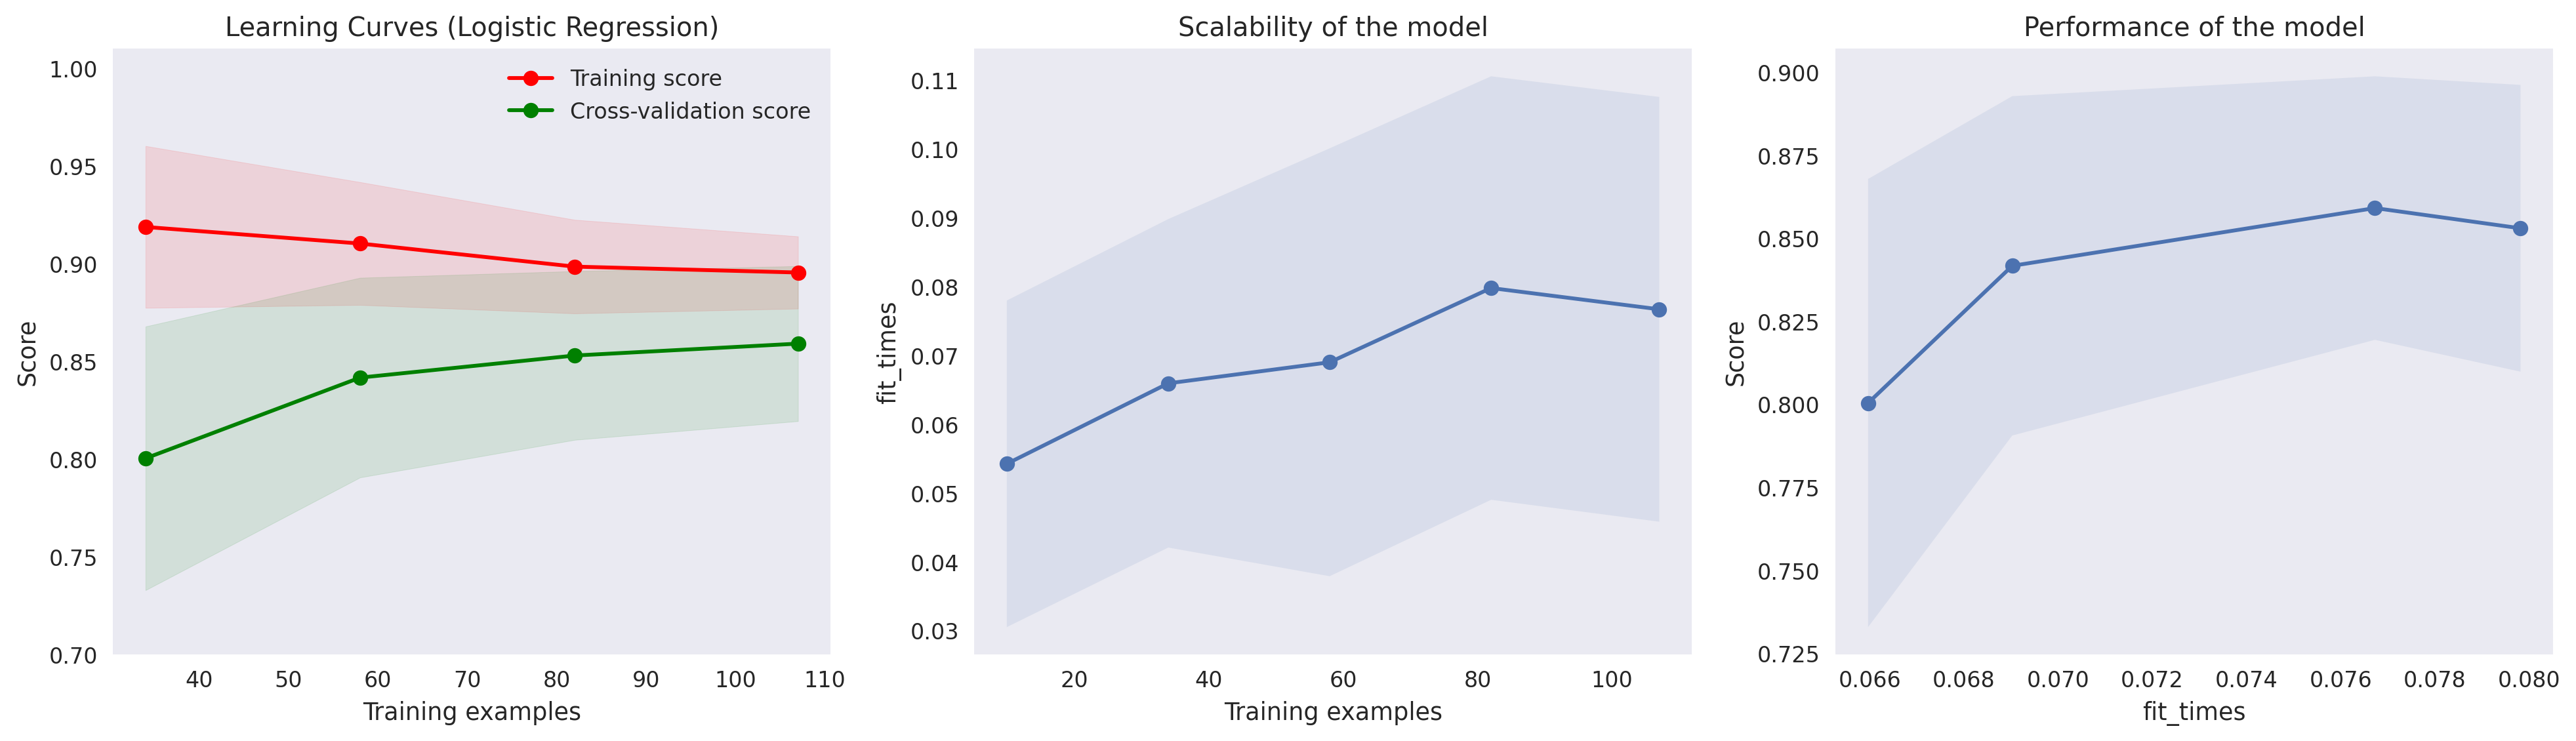

In [126]:
title = "Learning Curves (Logistic Regression)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.3, random_state=0)

plot_learning_curve(
    logistic_pipeline4["classifier"], title, X_train_enn, y_train_enn, axes=None, ylim=(0.7, 1.01), cv=cv, n_jobs=-1
)

plt.show()

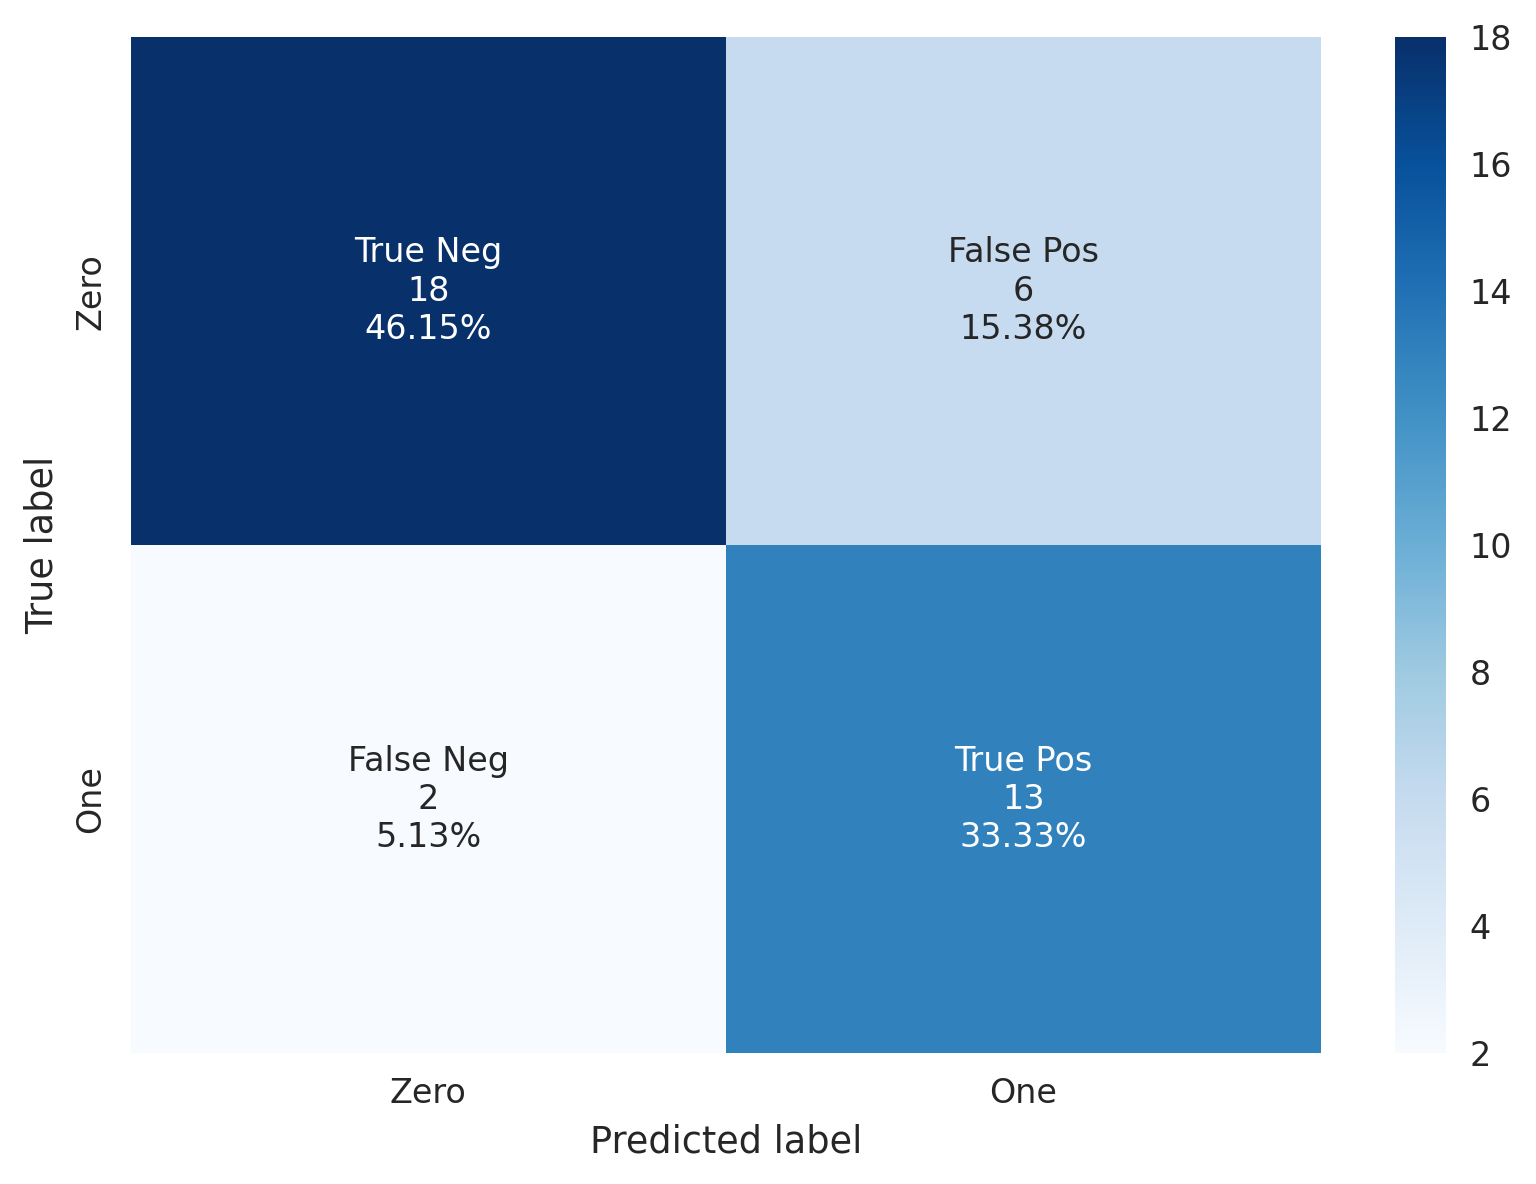

In [127]:
cf_matrix4 = confusion_matrix(y_test_enn, y_pred4)

group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
categories = ["Zero", "One"]
make_confusion_matrix(cf_matrix4, 
                      group_names=group_names,
                      categories=categories, sum_stats=None) 

In [128]:
print(classification_report(y_test_enn, y_pred4))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        24
           1       0.68      0.87      0.76        15

    accuracy                           0.79        39
   macro avg       0.79      0.81      0.79        39
weighted avg       0.82      0.79      0.80        39



In [170]:
print(precision_score(y_test_enn, y_pred4))

0.6842105263157895


## Hyper-parameters optimization

### Optuna

In [407]:
def model_performance(model, X, y):
    """
    Get accuracy score on validation/test data from a trained model
    """
    y_pred = model.predict(X)
    return np.round(precision_score(y_pred, y), 3)

In [408]:
def objective(trial, X_train=X_train_sm, y_train=y_train_sm, X_test=X_test_sm, y_test=y_test_sm):
    params = {
        "solvers" : trial.suggest_categorical("solvers", ['newton-cg', 'lbfgs', 'liblinear']),
        "penalty" : trial.suggest_categorical("penalty", ['l2']),
        "c_values" : trial.suggest_int("c_values", 0.01, 100)
    }

    clf = logistic_pipeline2[-1].set_params(solver=params["solvers"], penalty=params["penalty"], C=params["c_values"])
    clf.fit(X_train, y_train)
    
    return model_performance(clf, X=X_test, y=y_test)

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

### Scikit-learn

In [399]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [24]:
params = {
        "solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        "penalty" : ['l2', 'l1', 'elasticnet'],
        "class_weight": ["balanced"],
        "dual": [True, False],
        "intercept_scaling":  [0.1, 0.5, 1],
        "C": [0.1, 1, 10, 20, 30, 50, 70, 90, 100],
        "multi_class": ['auto', 'ovr', 'multinomial']
}

In [25]:
cv = RepeatedStratifiedKFold(n_splits=10, random_state=0)
grid_search = GridSearchCV(estimator=logistic_pipeline2[-1], param_grid=params, n_jobs=-1, cv=cv, scoring='precision', error_score=0)
grid_result = grid_search.fit(X, y)

In [ ]:
grid_result.best_params_

In [183]:
params = {'C': 10,
    'class_weight': 'balanced',
    'dual': False,
    'multi_class': 'auto',
    'penalty': 'l2',
    'solver': 'lbfgs', 
    'n_jobs': -1, 
    'max_iter': 1000
}

model_optim = logistic_pipeline2[-1].set_params(**params)

In [184]:
model_optim.get_params()

{'C': 10,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Hyperopt - Bayesian Sequential Model-based optimization

In [109]:
X_sm, y_sm = sm.fit_resample(X, y)

In [110]:
def search_space():
    # sourcery skip: inline-immediately-returned-variable, merge-dict-assign
    space = {
            'warm_start' : hp.choice('warm_start', [True, False]),
            'fit_intercept' : hp.choice('fit_intercept', [True, False]),
            'tol' : hp.uniform('tol', 0.00001, 0.0001),
            'C' : hp.uniform('C', 0.05, 3),
            'penalty' : hp.choice('penalty', ['l2']),
            'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear']),
            'max_iter' : hp.choice('max_iter', range(100,1000)),
            'multi_class' : 'auto',
            'class_weight' : 'balanced'
        }

    space['model'] = "logistic_regression"

    return space

In [111]:
def get_precision_status(clf, X_, y_):
    prec = cross_val_score(clf, X_, y_, cv=10, scoring='precision').mean()
    return {'loss': -prec, 'status': STATUS_OK}  # since HyperOpt’s optimizer performs minimization, we add a negative sign to the cross-validation score

In [112]:
def obj_fnc(params):
    # model = params.get('model').lower()
    del params['model']
    clf = logistic_pipeline2[-1].set_params(**params)
    return(get_precision_status(clf, X_sm, y_sm))

In [113]:
hypopt_trials = Trials()
best_params = fmin(obj_fnc, search_space(), algo=tpe.suggest,
                    max_evals=1000, trials= hypopt_trials)
print(best_params)
print(hypopt_trials.best_trial['result']['loss'])

100%|██████████| 1000/1000 [06:13<00:00,  2.68trial/s, best loss: -0.8091522023627894]
{'C': 2.856731708885844, 'fit_intercept': 1, 'max_iter': 447, 'penalty': 0, 'solver': 2, 'tol': 1.068168586173638e-05, 'warm_start': 0}
-0.8091522023627894


In [ ]:
with open('dominostats.json', 'w') as f:
    f.write(json.dumps({"Algo": "logistic_regression", 
    "Precision": hypopt_trials.best_trial['result']['loss'], 
    "Best params" : best_params}))

-------------------------------